Note that this code was adapted from the pytorch macro search implementation of ENAS, credits to https://github.com/MengTianjian/enas-pytorch

In [ ]:
import os
import sys


import torch
import torch.nn as nn
import numpy as np
import time
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data.dataset import Subset
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.distributions.categorical import Categorical
import torch.nn.functional as F

Visualization

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

Arguments

In [ ]:
args = {
    'description':'ENAS',
    'search_for':'macro',
    'data_path':'export/data/',
    'output_filename':'ENAS',
    'resume':'',
    'batch_size':128,
    'num_epochs':30,
    'log_every':50,
    'eval_every_epochs':1,
    'seed':69,
    'cutout':0,
    'fixed_arc':False,
    'child_num_layers':12,
    'child_out_filters':36,
    'child_grad_bound':5.0,
    'child_l2_reg':0.00025,
    'child_num_branches':3,
    'child_keep_prob':0.9,
    'child_lr_max':0.05,
    'child_lr_min':0.0005,
    'child_lr_T':10,
    'controller_lstm_size':64,
    'controller_lstm_num_layers':1,
    'controller_entropy_weight':0.0001,
    'controller_train_every':1,
    'controller_num_aggregate':20,
    'controller_train_steps':50,
    'controller_lr':0.001,
    'controller_tanh_constant':1.5,
    'controller_op_tanh_reduce':2.5,
    'controller_skip_target':0.4,
    'controller_skip_weight':0.8,
    'controller_bl_dec':0.99
}

Helper Functions


In [ ]:
class Cutout(object):
    """Randomly mask out a patche from an image.
    Args:
        length (int): The length (in pixels) of each square patch.
        p (float): The probability of cutout being applied.
    """
    def __init__(self, length, p=0.5):
        self.length = length
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """

        if np.random.rand() < self.p:

            h = img.size(1)
            w = img.size(2)

            mask = np.ones((h, w), np.float32)

            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length, 0, h)
            y2 = np.clip(y + self.length, 0, h)
            x1 = np.clip(x - self.length, 0, w)
            x2 = np.clip(x + self.length, 0, w)

            mask[y1: y2, x1: x2] = 0.

            mask = torch.from_numpy(mask)
            mask = mask.expand_as(img)
            img = img * mask

        return img

In [ ]:
# class Logger(object):
#     def __init__(self, filename):
#         self.terminal = sys.stdout
#         self.log = open(filename, 'w')

#     def write(self, message):
#         self.terminal.write(message)
#         self.log.write(message)
#         self.log.flush()

#     def flush(self):
#         #this flush method is needed for python 3 compatibility.
#         #this handles the flush command by doing nothing.
#         #you might want to specify some extra behavior here.
#         pass

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Controller

In [ ]:
class Controller(nn.Module):
    '''
    https://github.com/melodyguan/enas/blob/master/src/cifar10/general_controller.py
    '''
    def __init__(self,
                 search_for="macro",
                 search_whole_channels=True,
                 num_layers=12,
                 num_branches=6,
                 out_filters=36,
                 lstm_size=32,
                 lstm_num_layers=2,
                 tanh_constant=1.5,
                 temperature=None,
                 skip_target=0.4,
                 skip_weight=0.8):
        super(Controller, self).__init__()

        self.search_for = search_for
        self.search_whole_channels = search_whole_channels
        self.num_layers = num_layers
        self.num_branches = num_branches
        self.out_filters = out_filters

        self.lstm_size = lstm_size
        self.lstm_num_layers = lstm_num_layers
        self.tanh_constant = tanh_constant
        self.temperature = temperature

        self.skip_target = skip_target
        self.skip_weight = skip_weight

        self._create_params()

    def _create_params(self):
        '''
        https://github.com/melodyguan/enas/blob/master/src/cifar10/general_controller.py#L83
        '''
        self.w_lstm = nn.LSTM(input_size=self.lstm_size,
                              hidden_size=self.lstm_size,
                              num_layers=self.lstm_num_layers)

        self.g_emb = nn.Embedding(1, self.lstm_size)  # Learn the starting input

        if self.search_whole_channels:
            self.w_emb = nn.Embedding(self.num_branches, self.lstm_size)
            self.w_soft = nn.Linear(self.lstm_size, self.num_branches, bias=False)
        else:
            assert False, "Not implemented error: search_whole_channels = False"

        self.w_attn_1 = nn.Linear(self.lstm_size, self.lstm_size, bias=False)
        self.w_attn_2 = nn.Linear(self.lstm_size, self.lstm_size, bias=False)
        self.v_attn = nn.Linear(self.lstm_size, 1, bias=False)

        self._reset_params()

    def _reset_params(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Embedding):
                nn.init.uniform_(m.weight, -0.1, 0.1)

        nn.init.uniform_(self.w_lstm.weight_hh_l0, -0.1, 0.1)
        nn.init.uniform_(self.w_lstm.weight_ih_l0, -0.1, 0.1)

    def forward(self):
        '''
        https://github.com/melodyguan/enas/blob/master/src/cifar10/general_controller.py#L126
        '''
        h0 = None  # setting h0 to None will initialize LSTM state with 0s

        anchors = []
        anchors_w_1 = []

        arc_seq = {}
        entropys = []
        log_probs = []
        skip_count = []
        skip_penaltys = []

        inputs = self.g_emb.weight
        skip_targets = torch.tensor([1.0 - self.skip_target, self.skip_target]).cuda()

        for layer_id in range(self.num_layers):
            if self.search_whole_channels:
                inputs = inputs.unsqueeze(0)
                output, hn = self.w_lstm(inputs, h0)
                output = output.squeeze(0)
                h0 = hn

                logit = self.w_soft(output)
                if self.temperature is not None:
                    logit /= self.temperature
                if self.tanh_constant is not None:
                    logit = self.tanh_constant * torch.tanh(logit)

                branch_id_dist = Categorical(logits=logit)
                branch_id = branch_id_dist.sample()

                arc_seq[str(layer_id)] = [branch_id]

                log_prob = branch_id_dist.log_prob(branch_id)
                log_probs.append(log_prob.view(-1))
                entropy = branch_id_dist.entropy()
                entropys.append(entropy.view(-1))

                inputs = self.w_emb(branch_id)
                inputs = inputs.unsqueeze(0)
            else:
                # https://github.com/melodyguan/enas/blob/master/src/cifar10/general_controller.py#L171
                assert False, "Not implemented error: search_whole_channels = False"

            output, hn = self.w_lstm(inputs, h0)
            output = output.squeeze(0)

            if layer_id > 0:
                query = torch.cat(anchors_w_1, dim=0)
                query = torch.tanh(query + self.w_attn_2(output))
                query = self.v_attn(query)
                logit = torch.cat([-query, query], dim=1)
                if self.temperature is not None:
                    logit /= self.temperature
                if self.tanh_constant is not None:
                    logit = self.tanh_constant * torch.tanh(logit)

                skip_dist = Categorical(logits=logit)
                skip = skip_dist.sample()
                skip = skip.view(layer_id)

                arc_seq[str(layer_id)].append(skip)

                skip_prob = torch.sigmoid(logit)
                kl = skip_prob * torch.log(skip_prob / skip_targets)
                kl = torch.sum(kl)
                skip_penaltys.append(kl)

                log_prob = skip_dist.log_prob(skip)
                log_prob = torch.sum(log_prob)
                log_probs.append(log_prob.view(-1))

                entropy = skip_dist.entropy()
                entropy = torch.sum(entropy)
                entropys.append(entropy.view(-1))

                # Calculate average hidden state of all nodes that got skips
                # and use it as input for next step
                skip = skip.type(torch.float)
                skip = skip.view(1, layer_id)
                skip_count.append(torch.sum(skip))
                inputs = torch.matmul(skip, torch.cat(anchors, dim=0))
                inputs /= (1.0 + torch.sum(skip))

            else:
                inputs = self.g_emb.weight

            anchors.append(output)
            anchors_w_1.append(self.w_attn_1(output))

        self.sample_arc = arc_seq

        entropys = torch.cat(entropys)
        self.sample_entropy = torch.sum(entropys)

        log_probs = torch.cat(log_probs)
        self.sample_log_prob = torch.sum(log_probs)

        skip_count = torch.stack(skip_count)
        self.skip_count = torch.sum(skip_count)

        skip_penaltys = torch.stack(skip_penaltys)
        self.skip_penaltys = torch.mean(skip_penaltys)

Child

In [ ]:
class FactorizedReduction(nn.Module):
    '''
    Reduce both spatial dimensions (width and height) by a factor of 2, and 
    potentially to change the number of output filters
    https://github.com/melodyguan/enas/blob/master/src/cifar10/general_child.py#L129
    '''

    def __init__(self, in_planes, out_planes, stride=2):
        super(FactorizedReduction, self).__init__()

        assert out_planes % 2 == 0, (
        "Need even number of filters when using this factorized reduction.")

        self.in_planes = in_planes
        self.out_planes = out_planes
        self.stride = stride

        if stride == 1:
            self.fr = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_planes, track_running_stats=False))
        else:
            self.path1 = nn.Sequential(
                nn.AvgPool2d(1, stride=stride),
                nn.Conv2d(in_planes, out_planes // 2, kernel_size=1, bias=False))

            self.path2 = nn.Sequential(
                nn.AvgPool2d(1, stride=stride),
                nn.Conv2d(in_planes, out_planes // 2, kernel_size=1, bias=False))
            self.bn = nn.BatchNorm2d(out_planes, track_running_stats=False)

    def forward(self, x):
        if self.stride == 1:
            return self.fr(x)
        else:
            path1 = self.path1(x)

            # pad the right and the bottom, then crop to include those pixels
            path2 = F.pad(x, pad=(0, 1, 0, 1), mode='constant', value=0.)
            path2 = path2[:, :, 1:, 1:]
            path2 = self.path2(path2)

            out = torch.cat([path1, path2], dim=1)
            out = self.bn(out)
            return out

class ENASLayer(nn.Module):
    '''
    https://github.com/melodyguan/enas/blob/master/src/cifar10/general_child.py#L245
    '''
    def __init__(self, layer_id, in_planes, out_planes):
        super(ENASLayer, self).__init__()

        self.layer_id = layer_id
        self.in_planes = in_planes
        self.out_planes = out_planes
#TAKE OUT 3 BY 3 CONVOLUTIONS, BOTH, TAKE OUT MAX POOL!
        self.branch_0 = ConvBranch(in_planes, out_planes, kernel_size=3)
        self.branch_1 = ConvBranch(in_planes, out_planes, kernel_size=3, separable=True)
        self.branch_2 = ConvBranch(in_planes, out_planes, kernel_size=5)
        self.branch_3 = ConvBranch(in_planes, out_planes, kernel_size=5, separable=True)
        self.branch_4 = PoolBranch(in_planes, out_planes, 'avg')
        self.branch_5 = PoolBranch(in_planes, out_planes, 'max')

        self.bn = nn.BatchNorm2d(out_planes, track_running_stats=False)

    def forward(self, x, prev_layers, sample_arc):
        layer_type = sample_arc[0]
        if self.layer_id > 0:
            skip_indices = sample_arc[1]
        else:
            skip_indices = []
        
        if layer_type == 0:
            out = self.branch_0(x)
        elif layer_type == 1:
            out = self.branch_1(x)
        elif layer_type == 2:
            out = self.branch_2(x)
        elif layer_type == 3:
            out = self.branch_3(x)
        elif layer_type == 4:
            out = self.branch_4(x)
        elif layer_type == 5:
            out = self.branch_5(x)
        else:
            raise ValueError("Unknown layer_type {}".format(layer_type))

        for i, skip in enumerate(skip_indices):
            if skip == 1:
                out += prev_layers[i]

        out = self.bn(out)
        return out

class FixedLayer(nn.Module):
    '''
    https://github.com/melodyguan/enas/blob/master/src/cifar10/general_child.py#L245
    '''
    def __init__(self, layer_id, in_planes, out_planes, sample_arc):
        super(FixedLayer, self).__init__()

        self.layer_id = layer_id
        self.in_planes = in_planes
        self.out_planes = out_planes
        self.sample_arc = sample_arc

        self.layer_type = sample_arc[0]
        if self.layer_id > 0:
            self.skip_indices = sample_arc[1]
        else:
            self.skip_indices = torch.zeros(1)

        
        if self.layer_type == 0:
            self.branch = ConvBranch(in_planes, out_planes, kernel_size=5)
        elif self.layer_type == 1:
            self.branch = ConvBranch(in_planes, out_planes, kernel_size=5, separable=True)
        elif self.layer_type == 2:
            self.branch = PoolBranch(in_planes, out_planes, 'avg')
      
        else:
            raise ValueError("Unknown layer_type {}".format(self.layer_type))

        # Use concatentation instead of addition in the fixed layer for some reason
        in_planes = int((torch.sum(self.skip_indices).item() + 1) * in_planes)
        self.dim_reduc = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(out_planes, track_running_stats=False))

    def forward(self, x, prev_layers, sample_arc):
        out = self.branch(x)

        res_layers = []
        for i, skip in enumerate(self.skip_indices):
            if skip == 1:
                res_layers.append(prev_layers[i])
        prev = res_layers + [out]
        prev = torch.cat(prev, dim=1)

        out = self.dim_reduc(prev)
        return out

class SeparableConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, bias):
        super(SeparableConv, self).__init__()
        padding = (kernel_size - 1) // 2
        self.depthwise = nn.Conv2d(in_planes, in_planes, kernel_size=kernel_size,
                                   padding=padding, groups=in_planes, bias=bias)
        self.pointwise = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class ConvBranch(nn.Module):
    '''
    https://github.com/melodyguan/enas/blob/master/src/cifar10/general_child.py#L483
    '''
    def __init__(self, in_planes, out_planes, kernel_size, separable=False):
        super(ConvBranch, self).__init__()
        assert kernel_size in [3,5], "Kernel size must be either 3 or 5"

        self.in_planes = in_planes
        self.out_planes = out_planes
        self.kernel_size = kernel_size
        self.separable = separable

        self.inp_conv1 = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_planes, track_running_stats=False),
            nn.ReLU())

        if separable:
            self.out_conv = nn.Sequential(
                SeparableConv(in_planes, out_planes, kernel_size=kernel_size, bias=False),
                nn.BatchNorm2d(out_planes, track_running_stats=False),
                nn.ReLU())
        else:
            padding = (kernel_size - 1) // 2
            self.out_conv = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size,
                          padding=padding, bias=False),
                nn.BatchNorm2d(out_planes, track_running_stats=False),
                nn.ReLU())

    def forward(self, x):
        out = self.inp_conv1(x)
        out = self.out_conv(out)
        return out

class PoolBranch(nn.Module):
    '''
    https://github.com/melodyguan/enas/blob/master/src/cifar10/general_child.py#L546
    '''
    def __init__(self, in_planes, out_planes, avg_or_max):
        super(PoolBranch, self).__init__()

        self.in_planes = in_planes
        self.out_planes = out_planes
        self.avg_or_max = avg_or_max

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_planes, track_running_stats=False),
            nn.ReLU())

        if avg_or_max == 'avg':
            self.pool = torch.nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        elif avg_or_max == 'max':
            self.pool = torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        else:
            raise ValueError("Unknown pool {}".format(avg_or_max))

    def forward(self, x):
        out = self.conv1(x)
        out = self.pool(out)
        return out

class SharedCNN(nn.Module):
    def __init__(self,
                 num_layers=12,
                 num_branches=6,
                 out_filters=24,
                 keep_prob=1.0,
                 fixed_arc=None
                 ):
        super(SharedCNN, self).__init__()

        self.num_layers = num_layers
        self.num_branches = num_branches
        self.out_filters = out_filters
        self.keep_prob = keep_prob
        self.fixed_arc = fixed_arc

        pool_distance = self.num_layers // 3
        self.pool_layers = [pool_distance - 1, 2 * pool_distance - 1]

        self.stem_conv = nn.Sequential(
            nn.Conv2d(3, out_filters, kernel_size=3, padding=1, bias=False),
            # nn.Conv2d(1, out_filters, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_filters, track_running_stats=False))

        self.layers = nn.ModuleList([])
        self.pooled_layers = nn.ModuleList([])

        for layer_id in range(self.num_layers):
            if self.fixed_arc is None:
                layer = ENASLayer(layer_id, self.out_filters, self.out_filters)
            else:
                layer = FixedLayer(layer_id, self.out_filters, self.out_filters, self.fixed_arc[str(layer_id)])
            self.layers.append(layer)

            if layer_id in self.pool_layers:
                for i in range(len(self.layers)):
                    if self.fixed_arc is None:
                        self.pooled_layers.append(FactorizedReduction(self.out_filters, self.out_filters))
                    else:
                        self.pooled_layers.append(FactorizedReduction(self.out_filters, self.out_filters * 2))
                if self.fixed_arc is not None:
                    self.out_filters *= 2

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=1. - self.keep_prob)
        self.classify = nn.Linear(self.out_filters, 10)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x, sample_arc):

        x = self.stem_conv(x)

        prev_layers = []
        pool_count = 0
        for layer_id in range(self.num_layers):
            x = self.layers[layer_id](x, prev_layers, sample_arc[str(layer_id)])
            prev_layers.append(x)
            if layer_id in self.pool_layers:
                for i, prev_layer in enumerate(prev_layers):
                    # Go through the outputs of all previous layers and downsample them
                    prev_layers[i] = self.pooled_layers[pool_count](prev_layer)
                    pool_count += 1
                x = prev_layers[-1]

        x = self.global_avg_pool(x)
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        out = self.classify(x)

        return out

Training

In [ ]:
def train_shared_cnn(epoch,
                     controller,
                     shared_cnn,
                     data_loaders,
                     shared_cnn_optimizer,
                     fixed_arc=None):
    """Train shared_cnn by sampling architectures from the controller.
    Args:
        epoch: Current epoch.
        controller: Controller module that generates architectures to be trained.
        shared_cnn: CNN that contains all possible architectures, with shared weights.
        data_loaders: Dict containing data loaders.
        shared_cnn_optimizer: Optimizer for the shared_cnn.
        fixed_arc: Architecture to train, overrides the controller sample
        ...
    
    Returns: Nothing.
    """

    controller.eval()

    if fixed_arc is None:
        # Use a subset of the training set when searching for an arhcitecture
        train_loader = data_loaders['train_subset']
    else:
        # Use the full training set when training a fixed architecture
        train_loader = data_loaders['train_dataset']

    train_acc_meter = AverageMeter()
    loss_meter = AverageMeter()

    for i, (images, labels) in enumerate(train_loader):
        start = time.time()
        images = images.cuda()
        labels = labels.cuda()

        if fixed_arc is None:
            with torch.no_grad():
                controller()  # perform forward pass to generate a new architecture
            sample_arc = controller.sample_arc
        else:
            sample_arc = fixed_arc

        shared_cnn.zero_grad()
        pred = shared_cnn(images, sample_arc)
        loss = nn.CrossEntropyLoss()(pred, labels)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(shared_cnn.parameters(), args['child_grad_bound'])
        shared_cnn_optimizer.step()

        train_acc = torch.mean((torch.max(pred, 1)[1] == labels).type(torch.float))

        train_acc_meter.update(train_acc.item())
        loss_meter.update(loss.item())

        end = time.time()

        if (i) % args['log_every'] == 0:
            learning_rate = shared_cnn_optimizer.param_groups[0]['lr']
            display = 'epoch=' + str(epoch) + \
                      '\tch_step=' + str(i) + \
                      '\tloss=%.6f' % (loss_meter.val) + \
                      '\tlr=%.4f' % (learning_rate) + \
                      '\t|g|=%.4f' % (grad_norm.item()) + \
                      '\tacc=%.4f' % (train_acc_meter.val) + \
                      '\ttime=%.2fit/s' % (1. / (end - start))
            print(display)

    
    # vis_win['shared_cnn_acc'] = vis.line(
    #     X=np.array([epoch]),
    #     Y=np.array([train_acc_meter.avg]),
    #     win=vis_win['shared_cnn_acc'],
    #     opts=dict(title='shared_cnn_acc', xlabel='Iteration', ylabel='Accuracy'),
    #     update='append' if epoch > 0 else None)

    plt.figure()
    plt.plot(np.array([epoch]),
             np.array([train_acc_meter.avg]),
             'ro-',
             label='Shared CNN Accuracy')
    plt.plot(np.array([epoch]),
             np.array([loss_meter.avg]),
             'go-',
             label='Shared CNN Loss')
    plt.legend()
    plt.title('Shared CNN')
    plt.xlabel('Iteration')
    plt.savefig("child_training_curve.png")
    plt.show()

    # vis_win['shared_cnn_loss'] = vis.line(
    #     X=np.array([epoch]),
    #     Y=np.array([loss_meter.avg]),
    #     win=vis_win['shared_cnn_loss'],
    #     opts=dict(title='shared_cnn_loss', xlabel='Iteration', ylabel='Loss'),
    #     update='append' if epoch > 0 else None)

    controller.train()

def train_controller(epoch,
                     controller,
                     shared_cnn,
                     data_loaders,
                     controller_optimizer,
                     baseline=None):
    """Train controller to optimizer validation accuracy using REINFORCE.
    Args:
        epoch: Current epoch.
        controller: Controller module that generates architectures to be trained.
        shared_cnn: CNN that contains all possible architectures, with shared weights.
        data_loaders: Dict containing data loaders.
        controller_optimizer: Optimizer for the controller.
        baseline: The baseline score (i.e. average val_acc) from the previous epoch
    
    Returns: 
        baseline: The baseline score (i.e. average val_acc) for the current epoch
    For more stable training we perform weight updates using the average of
    many gradient estimates. controller_num_aggregate indicates how many samples
    we want to average over (default = 20). By default PyTorch will sum gradients
    each time .backward() is called (as long as an optimizer step is not taken),
    so each iteration we divide the loss by controller_num_aggregate to get the 
    average.
    https://github.com/melodyguan/enas/blob/master/src/cifar10/general_controller.py#L270
    """
    print('Epoch ' + str(epoch) + ': Training controller')

    shared_cnn.eval()
    valid_loader = data_loaders['valid_subset']

    reward_meter = AverageMeter()
    baseline_meter = AverageMeter()
    val_acc_meter = AverageMeter()
    loss_meter = AverageMeter()

    controller.zero_grad()
    for i in range(args['controller_train_steps'] * args['controller_num_aggregate']):
        start = time.time()
        images, labels = next(iter(valid_loader))
        images = images.cuda()
        labels = labels.cuda()

        controller()  # perform forward pass to generate a new architecture
        sample_arc = controller.sample_arc

        with torch.no_grad():
            pred = shared_cnn(images, sample_arc)
        val_acc = torch.mean((torch.max(pred, 1)[1] == labels).type(torch.float))

        # detach to make sure that gradients aren't backpropped through the reward
        reward = torch.tensor(val_acc.detach())
        reward += args['controller_entropy_weight'] * controller.sample_entropy

        if baseline is None:
            baseline = val_acc
        else:
            baseline -= (1 - args['controller_bl_dec']) * (baseline - reward)
            # detach to make sure that gradients are not backpropped through the baseline
            baseline = baseline.detach()

        loss = -1 * controller.sample_log_prob * (reward - baseline)

        if args['controller_skip_weight'] is not None:
            loss += args['controller_skip_weight'] * controller.skip_penaltys

        reward_meter.update(reward.item())
        baseline_meter.update(baseline.item())
        val_acc_meter.update(val_acc.item())
        loss_meter.update(loss.item())

        # Average gradient over controller_num_aggregate samples
        loss = loss / args['controller_num_aggregate']

        loss.backward(retain_graph=True)

        end = time.time()

        # Aggregate gradients for controller_num_aggregate iterationa, then update weights
        if (i + 1) % args['controller_num_aggregate'] == 0:
            grad_norm = torch.nn.utils.clip_grad_norm_(controller.parameters(), args['child_grad_bound'])
            controller_optimizer.step()
            controller.zero_grad()

            if (i + 1) % (2 * args['controller_num_aggregate']) == 0:
                learning_rate = controller_optimizer.param_groups[0]['lr']
                display = 'ctrl_step=' + str(i // args['controller_num_aggregate']) + \
                          '\tloss=%.3f' % (loss_meter.val) + \
                          '\tent=%.2f' % (controller.sample_entropy.item()) + \
                          '\tlr=%.4f' % (learning_rate) + \
                          '\t|g|=%.4f' % (grad_norm.item()) + \
                          '\tacc=%.4f' % (val_acc_meter.val) + \
                          '\tbl=%.2f' % (baseline_meter.val) + \
                          '\ttime=%.2fit/s' % (1. / (end - start))
                print(display)
      
    plt.figure()
    plt.plot(np.column_stack([epoch] * 2), 
             np.column_stack([reward_meter.avg, baseline_meter.avg]), 
             'go-',
             label='Controller Reward')
    
    plt.plot(np.array([epoch]),
             np.array([val_acc_meter.avg]),
             'ro-',
             label='Controller Accuracy')
    
    plt.plot(np.array([epoch]),
             np.array([loss_meter.avg]),
             'bo-',
             label='Controller Loss')
    plt.legend()
    plt.title('Controller')
    plt.xlabel('Iteration')
    plt.savefig("controller_training_curve.png")
    plt.show()
    
    # vis_win['controller_reward'] = vis.line(
    #     X=np.column_stack([epoch] * 2),
    #     Y=np.column_stack([reward_meter.avg, baseline_meter.avg]),
    #     win=vis_win['controller_reward'],
    #     opts=dict(title='controller_reward', xlabel='Iteration', ylabel='Reward'),
    #     update='append' if epoch > 0 else None)

    # vis_win['controller_acc'] = vis.line(
    #     X=np.array([epoch]),
    #     Y=np.array([val_acc_meter.avg]),
    #     win=vis_win['controller_acc'],
    #     opts=dict(title='controller_acc', xlabel='Iteration', ylabel='Accuracy'),
    #     update='append' if epoch > 0 else None)

    # vis_win['controller_loss'] = vis.line(
    #     X=np.array([epoch]),
    #     Y=np.array([loss_meter.avg]),
    #     win=vis_win['controller_loss'],
    #     opts=dict(title='controller_loss', xlabel='Iteration', ylabel='Loss'),
    #     update='append' if epoch > 0 else None)

    shared_cnn.train()
    return baseline

def train_enas(start_epoch,
               controller,
               shared_cnn,
               data_loaders,
               shared_cnn_optimizer,
               controller_optimizer,
               shared_cnn_scheduler):
    """Perform architecture search by training a controller and shared_cnn.
    Args:
        start_epoch: Epoch to begin on.
        controller: Controller module that generates architectures to be trained.
        shared_cnn: CNN that contains all possible architectures, with shared weights.
        data_loaders: Dict containing data loaders.
        shared_cnn_optimizer: Optimizer for the shared_cnn.
        controller_optimizer: Optimizer for the controller.
        shared_cnn_scheduler: Learning rate schedular for shared_cnn_optimizer
    
    Returns: Nothing.
    """

    baseline = None
    for epoch in range(start_epoch, args['num_epochs']):

        train_shared_cnn(epoch,
                         controller,
                         shared_cnn,
                         data_loaders,
                         shared_cnn_optimizer)

        baseline = train_controller(epoch,
                                    controller,
                                    shared_cnn,
                                    data_loaders,
                                    controller_optimizer,
                                    baseline)

        if epoch % args['eval_every_epochs'] == 0:
            evaluate_model(epoch, controller, shared_cnn, data_loaders)

        # shared_cnn_scheduler.step(epoch)
        shared_cnn_scheduler.step()

        state = {'epoch': epoch + 1,
                 'args': args,
                 'shared_cnn_state_dict': shared_cnn.state_dict(),
                 'controller_state_dict': controller.state_dict(),
                 'shared_cnn_optimizer': shared_cnn_optimizer.state_dict(),
                 'controller_optimizer': controller_optimizer.state_dict()}
        filename = args['output_filename'] + '.pth.tar'
        torch.save(state, filename)

def train_fixed(start_epoch,
                controller,
                shared_cnn,
                data_loaders):
    """Train a fixed cnn architecture.
    Args:
        start_epoch: Epoch to begin on.
        controller: Controller module that generates architectures to be trained.
        shared_cnn: CNN that contains all possible architectures, with shared weights.
        data_loaders: Dict containing data loaders.
    
    Returns: Nothing.
    Given a fully trained controller and shared_cnn, we sample many architectures,
    and then train a new cnn from scratch using the best architecture we found. 
    We change the number of filters in the new cnn such that the final layer 
    has 512 channels.
    """

    best_arc, best_val_acc = get_best_arc(controller, shared_cnn, data_loaders, n_samples=100, verbose=True)
    print('Best architecture:')
    print_arc(best_arc)
    print('Validation accuracy: ' + str(best_val_acc))

    fixed_cnn = SharedCNN(num_layers=args['child_num_layers'],
                          num_branches=args['child_num_branches'],
                          out_filters=512 // 4,  # args.child_out_filters
                          keep_prob=args['child_keep_prob'],
                          fixed_arc=best_arc)
    fixed_cnn = fixed_cnn.cuda()

    fixed_cnn_optimizer = torch.optim.SGD(params=fixed_cnn.parameters(),
                                          lr=args['child_lr_max'],
                                          momentum=0.9,
                                          nesterov=True,
                                          weight_decay=args['child_l2_reg'])

    fixed_cnn_scheduler = CosineAnnealingLR(optimizer=fixed_cnn_optimizer,
                                            T_max=args['child_lr_T'],
                                            eta_min=args['child_lr_min'])

    test_loader = data_loaders['test_dataset']

    for epoch in range(args['num_epochs']):

        train_shared_cnn(epoch,
                         controller,  # not actually used in training the fixed_cnn
                         fixed_cnn,
                         data_loaders,
                         fixed_cnn_optimizer,
                         best_arc)

        if epoch % args['eval_every_epochs'] == 0:
            test_acc = get_eval_accuracy(test_loader, fixed_cnn, best_arc)
            print('Epoch ' + str(epoch) + ': Eval')
            print('test_accuracy: %.4f' % (test_acc))

        fixed_cnn_scheduler.step()

        state = {'epoch': epoch + 1,
                 'args': args,
                 'best_arc': best_arc,
                 'fixed_cnn_state_dict': shared_cnn.state_dict(),
                 'fixed_cnn_optimizer': fixed_cnn_optimizer.state_dict()}
        filename = args['output_filename'] + '_fixed.pth.tar'
        torch.save(state, filename)


Evaluation


In [ ]:
def evaluate_model(epoch, controller, shared_cnn, data_loaders, n_samples=10):
    """Print the validation and test accuracy for a controller and shared_cnn.
    Args:
        epoch: Current epoch.
        controller: Controller module that generates architectures to be trained.
        shared_cnn: CNN that contains all possible architectures, with shared weights.
        data_loaders: Dict containing data loaders.
        n_samples: Number of architectures to test when looking for the best one.
    
    Returns: Nothing.
    """

    controller.eval()
    shared_cnn.eval()

    print('Here are ' + str(n_samples) + ' architectures:')
    best_arc, _ = get_best_arc(controller, shared_cnn, data_loaders, n_samples, verbose=True)

    valid_loader = data_loaders['valid_subset']
    test_loader = data_loaders['test_dataset']

    valid_acc = get_eval_accuracy(valid_loader, shared_cnn, best_arc)
    test_acc = get_eval_accuracy(test_loader, shared_cnn, best_arc)

    print('Epoch ' + str(epoch) + ': Eval')
    print('valid_accuracy: %.4f' % (valid_acc))
    print('test_accuracy: %.4f' % (test_acc))

    controller.train()
    shared_cnn.train()

def get_best_arc(controller, shared_cnn, data_loaders, n_samples=10, verbose=False):
    """Evaluate several architectures and return the best performing one.
    Args:
        controller: Controller module that generates architectures to be trained.
        shared_cnn: CNN that contains all possible architectures, with shared weights.
        data_loaders: Dict containing data loaders.
        n_samples: Number of architectures to test when looking for the best one.
        verbose: If True, display the architecture and resulting validation accuracy.
    
    Returns:
        best_arc: The best performing architecture.
        best_vall_acc: Accuracy achieved on the best performing architecture.
    All architectures are evaluated on the same minibatch from the validation set.
    """

    controller.eval()
    shared_cnn.eval()

    valid_loader = data_loaders['valid_subset']

    images, labels = next(iter(valid_loader))
    images = images.cuda()
    labels = labels.cuda()

    arcs = []
    val_accs = []
    for i in range(n_samples):
        with torch.no_grad():
            controller()  # perform forward pass to generate a new architecture
        sample_arc = controller.sample_arc
        arcs.append(sample_arc)

        with torch.no_grad():
            pred = shared_cnn(images, sample_arc)
        val_acc = torch.mean((torch.max(pred, 1)[1] == labels).type(torch.float))
        val_accs.append(val_acc.item())

        if verbose:
            print_arc(sample_arc)
            print('val_acc=' + str(val_acc.item()))
            print('-' * 80)

    best_iter = np.argmax(val_accs)
    best_arc = arcs[best_iter]
    best_val_acc = val_accs[best_iter]

    controller.train()
    shared_cnn.train()
    return best_arc, best_val_acc

def get_eval_accuracy(loader, shared_cnn, sample_arc):
    """Evaluate a given architecture.
    Args:
        loader: A single data loader.
        shared_cnn: CNN that contains all possible architectures, with shared weights.
        sample_arc: The architecture to use for the evaluation.
    
    Returns:
        acc: Average accuracy.
    """
    total = 0.
    acc_sum = 0.
    for (images, labels) in loader:
        images = images.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            pred = shared_cnn(images, sample_arc)
        acc_sum += torch.sum((torch.max(pred, 1)[1] == labels).type(torch.float))
        total += pred.shape[0]

    acc = acc_sum / total
    return acc.item()

def print_arc(sample_arc):
    """Display a sample architecture in a readable format.
    
    Args: 
        sample_arc: The architecture to display.
    Returns: Nothing.
    """
    for key, value in sample_arc.items():
        if len(value) == 1:
            branch_type = value[0].cpu().numpy().tolist()
            print('[' + ' '.join(str(n) for n in branch_type) + ']')
        else:
            branch_type = value[0].cpu().numpy().tolist()
            skips = value[1].cpu().numpy().tolist()
            print('[' + ' '.join(str(n) for n in (branch_type + skips)) + ']')

Load MNIST data


In [ ]:
def load_datasets():
    """Create data loaders for the CIFAR-10 dataset.
    Returns: Dict containing data loaders.
    """
    normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize])

    if args['cutout'] > 0:
        train_transform.transforms.append(Cutout(length=args['cutout']))

    valid_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize])

    train_dataset = datasets.CIFAR10(root=args['data_path'],
                                     train=True,
                                     transform=train_transform,
                                     download=True)

    valid_dataset = datasets.CIFAR10(root=args['data_path'],
                                     train=True,
                                     transform=valid_transform,
                                     download=True)

    test_dataset = datasets.CIFAR10(root=args['data_path'],
                                    train=False,
                                    transform=test_transform,
                                    download=True)

    train_indices = list(range(0, 45000))
    valid_indices = list(range(45000, 50000))
    train_subset = Subset(train_dataset, train_indices)
    valid_subset = Subset(valid_dataset, valid_indices)

    data_loaders = {}
    data_loaders['train_subset'] = torch.utils.data.DataLoader(dataset=train_subset,
                                                               batch_size=args['batch_size'],
                                                               shuffle=True,
                                                               pin_memory=True,
                                                               num_workers=2)

    data_loaders['valid_subset'] = torch.utils.data.DataLoader(dataset=valid_subset,
                                                               batch_size=args['batch_size'],
                                                               shuffle=True,
                                                               pin_memory=True,
                                                               num_workers=2,
                                                               drop_last=True)

    data_loaders['train_dataset'] = torch.utils.data.DataLoader(dataset=train_dataset,
                                                                batch_size=args['batch_size'],
                                                                shuffle=True,
                                                                pin_memory=True,
                                                                num_workers=2)

    data_loaders['test_dataset'] = torch.utils.data.DataLoader(dataset=test_dataset,
                                                               batch_size=args['batch_size'],
                                                               shuffle=False,
                                                               pin_memory=True,
                                                               num_workers=2)

    return data_loaders

Set seed

In [ ]:
np.random.seed(args['seed'])
torch.cuda.manual_seed(args['seed'])

In [ ]:
# if args['fixed_arc']:
#     sys.stdout = Logger(filename='logs/' + args['output_filename'] + '_fixed.log')
# else:
#     sys.stdout = Logger(filename='logs/' + args['output_filename'] + '.log')

print("\n".join("{}\t{}".format(k, v) for k, v in args.items()))

description	ENAS
search_for	macro
data_path	export/data/
output_filename	ENAS
resume	
batch_size	128
num_epochs	30
log_every	50
eval_every_epochs	1
seed	69
cutout	0
fixed_arc	False
child_num_layers	12
child_out_filters	36
child_grad_bound	5.0
child_l2_reg	0.00025
child_num_branches	3
child_keep_prob	0.9
child_lr_max	0.05
child_lr_min	0.0005
child_lr_T	10
controller_lstm_size	64
controller_lstm_num_layers	1
controller_entropy_weight	0.0001
controller_train_every	1
controller_num_aggregate	20
controller_train_steps	50
controller_lr	0.001
controller_tanh_constant	1.5
controller_op_tanh_reduce	2.5
controller_skip_target	0.4
controller_skip_weight	0.8
controller_bl_dec	0.99


Create data loaders

In [ ]:
data_loaders = load_datasets()


Extracting export/data/cifar-10-python.tar.gz to export/data/
Files already downloaded and verified
Files already downloaded and verified


Create controller

In [ ]:
controller = Controller(search_for=args['search_for'],
                        search_whole_channels=True,
                        num_layers=args['child_num_layers'],
                        num_branches=args['child_num_branches'],
                        out_filters=args['child_out_filters'],
                        lstm_size=args['controller_lstm_size'],
                        lstm_num_layers=args['controller_lstm_num_layers'],
                        tanh_constant=args['controller_tanh_constant'],
                        temperature=None,
                        skip_target=args['controller_skip_target'],
                        skip_weight=args['controller_skip_weight'])
controller = controller.cuda()

Child architectures

In [ ]:
shared_cnn = SharedCNN(num_layers=args['child_num_layers'],
                        num_branches=args['child_num_branches'],
                        out_filters=args['child_out_filters'],
                        keep_prob=args['child_keep_prob'])

shared_cnn = shared_cnn.cuda()

Adam optimizer for controller

In [ ]:
# https://github.com/melodyguan/enas/blob/master/src/utils.py#L218
controller_optimizer = torch.optim.Adam(params=controller.parameters(),
                                        lr=args['controller_lr'],
                                        betas=(0.0, 0.999),
                                        eps=1e-3)

SGD optimizer for childs

In [ ]:
# https://github.com/melodyguan/enas/blob/master/src/utils.py#L213
shared_cnn_optimizer = torch.optim.SGD(params=shared_cnn.parameters(),
                                        lr=args['child_lr_max'],
                                        momentum=0.9,
                                        nesterov=True,
                                        weight_decay=args['child_l2_reg'])

Child learning rate

In [ ]:
# https://github.com/melodyguan/enas/blob/master/src/utils.py#L154
shared_cnn_scheduler = CosineAnnealingLR(optimizer=shared_cnn_optimizer,
                                          T_max=args['child_lr_T'],
                                          eta_min=args['child_lr_min'])

epoch=0	ch_step=0	loss=2.326638	lr=0.0500	|g|=0.5642	acc=0.1172	time=2.27it/s
epoch=0	ch_step=50	loss=2.259871	lr=0.0500	|g|=0.6567	acc=0.1016	time=5.01it/s
epoch=0	ch_step=100	loss=2.010729	lr=0.0500	|g|=0.5977	acc=0.2422	time=5.11it/s
epoch=0	ch_step=150	loss=1.946116	lr=0.0500	|g|=0.5096	acc=0.3125	time=4.81it/s
epoch=0	ch_step=200	loss=1.916308	lr=0.0500	|g|=0.8462	acc=0.2578	time=4.97it/s
epoch=0	ch_step=250	loss=1.852486	lr=0.0500	|g|=0.8078	acc=0.2656	time=5.04it/s
epoch=0	ch_step=300	loss=1.852606	lr=0.0500	|g|=0.8130	acc=0.3125	time=4.71it/s
epoch=0	ch_step=350	loss=1.819196	lr=0.0500	|g|=0.8549	acc=0.3281	time=5.80it/s


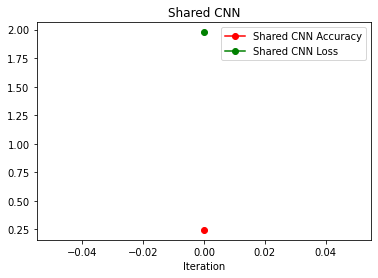

Epoch 0: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=1.616	ent=58.87	lr=0.0010	|g|=0.3432	acc=0.2891	bl=0.27	time=3.01it/s
ctrl_step=3	loss=6.240	ent=58.69	lr=0.0010	|g|=0.2661	acc=0.3828	bl=0.28	time=3.00it/s
ctrl_step=5	loss=2.884	ent=58.42	lr=0.0010	|g|=0.2299	acc=0.3359	bl=0.29	time=3.11it/s
ctrl_step=7	loss=-0.677	ent=58.02	lr=0.0010	|g|=0.2399	acc=0.2812	bl=0.30	time=3.08it/s
ctrl_step=9	loss=-0.524	ent=57.39	lr=0.0010	|g|=0.1210	acc=0.2812	bl=0.30	time=2.92it/s
ctrl_step=11	loss=0.819	ent=56.96	lr=0.0010	|g|=0.2650	acc=0.3047	bl=0.30	time=3.01it/s
ctrl_step=13	loss=-3.668	ent=56.08	lr=0.0010	|g|=0.2454	acc=0.2266	bl=0.30	time=3.03it/s
ctrl_step=15	loss=-1.883	ent=55.04	lr=0.0010	|g|=0.1400	acc=0.2578	bl=0.30	time=2.93it/s


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f689e5fd5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _error_if_

ctrl_step=17	loss=3.141	ent=54.99	lr=0.0010	|g|=0.1738	acc=0.3438	bl=0.29	time=3.04it/s
ctrl_step=19	loss=-0.563	ent=54.07	lr=0.0010	|g|=0.1619	acc=0.2734	bl=0.29	time=3.01it/s
ctrl_step=21	loss=1.302	ent=54.21	lr=0.0010	|g|=0.0387	acc=0.3047	bl=0.29	time=2.91it/s


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)


ctrl_step=23	loss=-0.195	ent=54.31	lr=0.0010	|g|=0.2935	acc=0.2812	bl=0.29	time=3.05it/s
ctrl_step=25	loss=0.660	ent=53.34	lr=0.0010	|g|=0.0868	acc=0.2969	bl=0.29	time=2.90it/s
ctrl_step=27	loss=0.969	ent=53.84	lr=0.0010	|g|=0.0590	acc=0.2969	bl=0.28	time=3.05it/s


Traceback (most recent call last):


ctrl_step=29	loss=0.119	ent=53.96	lr=0.0010	|g|=0.0330	acc=0.2812	bl=0.28	time=2.91it/s
ctrl_step=31	loss=-0.628	ent=52.91	lr=0.0010	|g|=0.0600	acc=0.2656	bl=0.28	time=3.02it/s


Traceback (most recent call last):


ctrl_step=33	loss=1.043	ent=53.42	lr=0.0010	|g|=0.0991	acc=0.2969	bl=0.28	time=2.90it/s
ctrl_step=35	loss=4.947	ent=53.59	lr=0.0010	|g|=0.0991	acc=0.3750	bl=0.29	time=3.03it/s
ctrl_step=37	loss=-0.358	ent=54.16	lr=0.0010	|g|=0.1877	acc=0.2734	bl=0.29	time=2.89it/s
ctrl_step=39	loss=1.612	ent=53.50	lr=0.0010	|g|=0.2297	acc=0.3125	bl=0.29	time=2.89it/s
ctrl_step=41	loss=0.026	ent=53.55	lr=0.0010	|g|=0.1166	acc=0.2812	bl=0.29	time=2.89it/s
ctrl_step=43	loss=-2.139	ent=54.20	lr=0.0010	|g|=0.1898	acc=0.2422	bl=0.29	time=2.91it/s
ctrl_step=45	loss=-0.349	ent=54.10	lr=0.0010	|g|=0.0417	acc=0.2734	bl=0.29	time=2.92it/s
ctrl_step=47	loss=3.221	ent=54.32	lr=0.0010	|g|=0.1567	acc=0.3438	bl=0.29	time=2.99it/s
ctrl_step=49	loss=-1.237	ent=53.25	lr=0.0010	|g|=0.0968	acc=0.2578	bl=0.29	time=2.88it/s


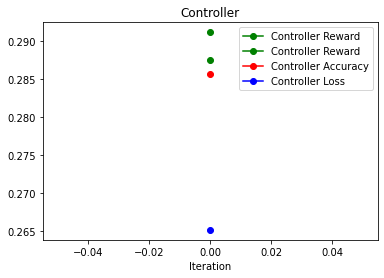

Here are 10 architectures:
[2]
[1 1]
[1 1 0]
[0 0 0 1]
[1 0 0 0 0]
[0 0 1 0 1 1]
[2 0 0 0 0 1 0]
[0 0 1 0 0 0 0 0]
[0 0 0 0 0 1 0 1 0]
[1 1 1 0 0 1 0 0 0 0]
[0 0 0 1 0 1 0 1 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0]
val_acc=0.15625
--------------------------------------------------------------------------------
[2]
[0 0]
[2 1 1]
[1 0 1 0]
[2 0 1 0 0]
[1 0 1 0 1 0]
[2 0 1 0 0 0 1]
[0 1 0 0 1 0 0 0]
[0 1 0 1 0 0 0 0 0]
[0 1 0 0 1 1 1 0 1 1]
[1 1 0 1 0 0 0 0 0 0 0]
[0 0 1 0 0 1 0 0 0 1 1 0]
val_acc=0.328125
--------------------------------------------------------------------------------
[2]
[1 1]
[2 0 0]
[0 0 0 0]
[2 0 1 0 0]
[1 1 1 0 0 0]
[0 0 1 0 0 0 1]
[2 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 1 1]
[2 0 0 1 0 0 1 0 1 0]
[2 0 1 0 0 1 0 1 0 1 1]
[0 1 1 1 0 0 1 0 0 0 0 0]
val_acc=0.3125
--------------------------------------------------------------------------------
[2]
[2 0]
[2 1 1]
[2 0 0 0]
[0 0 0 0 0]
[2 1 0 0 0 0]
[1 1 1 1 0 1 0]
[2 0 0 0 0 0 0 1]
[1 0 0 0 1 0 0 0 1]
[0 0 0 0 1 0 1 0 0 0]
[0 1 0 0 1 0

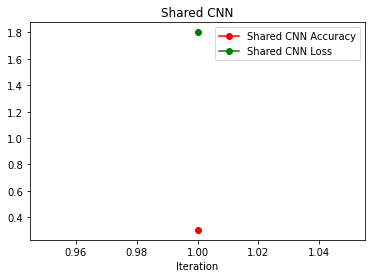

Epoch 1: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Traceback (most recent call last):


ctrl_step=1	loss=1.392	ent=52.31	lr=0.0010	|g|=0.1207	acc=0.3281	bl=0.30	time=3.10it/s
ctrl_step=3	loss=1.711	ent=52.31	lr=0.0010	|g|=0.1490	acc=0.3438	bl=0.32	time=3.15it/s
ctrl_step=5	loss=2.069	ent=51.73	lr=0.0010	|g|=0.0325	acc=0.3594	bl=0.32	time=2.96it/s


Traceback (most recent call last):


ctrl_step=7	loss=-0.622	ent=52.10	lr=0.0010	|g|=0.0341	acc=0.3125	bl=0.33	time=2.86it/s
ctrl_step=9	loss=-0.453	ent=51.87	lr=0.0010	|g|=0.2414	acc=0.3203	bl=0.33	time=3.19it/s
ctrl_step=11	loss=1.287	ent=51.14	lr=0.0010	|g|=0.1089	acc=0.3516	bl=0.33	time=2.81it/s
ctrl_step=13	loss=-3.300	ent=51.07	lr=0.0010	|g|=0.1158	acc=0.2656	bl=0.33	time=2.71it/s
ctrl_step=15	loss=0.534	ent=49.04	lr=0.0010	|g|=0.2538	acc=0.3359	bl=0.33	time=2.78it/s
ctrl_step=17	loss=-6.003	ent=50.18	lr=0.0010	|g|=0.2173	acc=0.2031	bl=0.33	time=3.19it/s
ctrl_step=19	loss=-4.231	ent=51.63	lr=0.0010	|g|=0.0607	acc=0.2500	bl=0.34	time=3.06it/s
ctrl_step=21	loss=0.113	ent=52.08	lr=0.0010	|g|=0.0626	acc=0.3359	bl=0.34	time=3.07it/s


Traceback (most recent call last):


ctrl_step=23	loss=-0.291	ent=52.52	lr=0.0010	|g|=0.0611	acc=0.3281	bl=0.34	time=2.81it/s
ctrl_step=25	loss=-2.393	ent=51.91	lr=0.0010	|g|=0.0856	acc=0.2891	bl=0.34	time=3.06it/s
ctrl_step=27	loss=-0.830	ent=51.82	lr=0.0010	|g|=0.0547	acc=0.3203	bl=0.34	time=2.75it/s
ctrl_step=29	loss=-1.654	ent=52.23	lr=0.0010	|g|=0.1342	acc=0.3047	bl=0.34	time=2.98it/s
ctrl_step=31	loss=-0.788	ent=52.18	lr=0.0010	|g|=0.0774	acc=0.3203	bl=0.34	time=2.98it/s
ctrl_step=33	loss=-1.899	ent=52.32	lr=0.0010	|g|=0.0933	acc=0.2969	bl=0.34	time=2.69it/s
ctrl_step=35	loss=5.072	ent=53.39	lr=0.0010	|g|=0.1599	acc=0.4297	bl=0.34	time=2.95it/s


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)


ctrl_step=37	loss=-0.833	ent=52.05	lr=0.0010	|g|=0.0753	acc=0.3203	bl=0.34	time=2.99it/s
ctrl_step=39	loss=1.532	ent=52.45	lr=0.0010	|g|=0.2471	acc=0.3672	bl=0.34	time=1.96it/s


Traceback (most recent call last):


ctrl_step=41	loss=1.563	ent=51.44	lr=0.0010	|g|=0.1002	acc=0.3672	bl=0.34	time=2.94it/s


Traceback (most recent call last):


ctrl_step=43	loss=-2.868	ent=51.85	lr=0.0010	|g|=0.0868	acc=0.2812	bl=0.34	time=2.74it/s
ctrl_step=45	loss=2.895	ent=51.38	lr=0.0010	|g|=0.1173	acc=0.3906	bl=0.34	time=3.05it/s
ctrl_step=47	loss=2.592	ent=52.13	lr=0.0010	|g|=0.1182	acc=0.3828	bl=0.34	time=2.90it/s
ctrl_step=49	loss=0.380	ent=52.91	lr=0.0010	|g|=0.1465	acc=0.3438	bl=0.34	time=2.99it/s


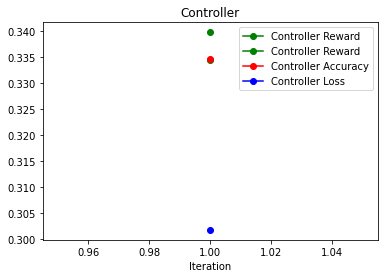

Here are 10 architectures:
[0]
[1 0]
[1 0 0]
[0 1 1 0]
[0 0 0 1 1]
[1 0 0 1 0 0]
[2 1 0 1 0 1 1]
[1 1 0 0 1 0 0 0]
[2 0 0 0 0 0 1 0 0]
[0 0 0 1 0 1 0 1 0 0]
[2 1 0 0 0 0 1 0 1 0 0]
[2 0 0 1 1 1 1 0 0 0 0 0]
val_acc=0.3984375
--------------------------------------------------------------------------------
[0]
[1 0]
[0 0 0]
[2 0 1 0]
[0 0 0 1 0]
[0 0 0 0 0 0]
[0 1 0 1 0 0 0]
[2 0 0 0 0 0 1 1]
[1 0 0 0 1 0 0 0 1]
[0 0 0 0 0 1 0 1 1 0]
[2 0 0 0 1 0 0 1 0 0 0]
[2 1 0 1 1 0 1 1 0 0 1 0]
val_acc=0.375
--------------------------------------------------------------------------------
[0]
[1 0]
[0 0 0]
[2 0 0 0]
[2 1 0 0 1]
[2 0 0 1 1 0]
[2 0 0 0 0 1 0]
[2 0 0 0 0 0 0 1]
[0 0 0 0 0 1 0 0 0]
[0 1 1 0 1 0 1 0 1 0]
[2 1 0 0 1 0 0 0 0 0 1]
[2 0 0 0 1 1 0 1 1 0 0 0]
val_acc=0.375
--------------------------------------------------------------------------------
[1]
[2 0]
[0 0 0]
[2 0 0 1]
[2 0 0 0 1]
[2 0 0 1 1 0]
[0 1 1 0 0 0 0]
[0 0 0 1 1 0 0 0]
[1 0 0 0 0 0 0 0 1]
[2 0 0 0 0 0 0 1 1 0]
[0 0 0 0 0 1 0

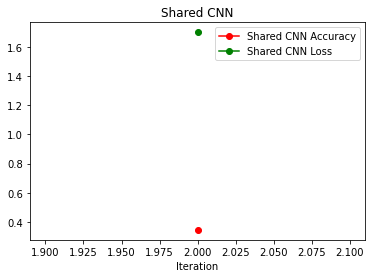

Epoch 2: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=-3.911	ent=52.04	lr=0.0010	|g|=0.0629	acc=0.2734	bl=0.35	time=2.69it/s
ctrl_step=3	loss=-1.250	ent=51.66	lr=0.0010	|g|=0.1617	acc=0.3281	bl=0.36	time=2.67it/s
ctrl_step=5	loss=-1.970	ent=52.37	lr=0.0010	|g|=0.0424	acc=0.3203	bl=0.36	time=2.64it/s
ctrl_step=7	loss=0.359	ent=52.15	lr=0.0010	|g|=0.1550	acc=0.3672	bl=0.37	time=2.59it/s
ctrl_step=9	loss=-0.517	ent=50.75	lr=0.0010	|g|=0.1342	acc=0.3516	bl=0.37	time=2.58it/s
ctrl_step=11	loss=-0.848	ent=51.03	lr=0.0010	|g|=0.1415	acc=0.3438	bl=0.37	time=2.83it/s
ctrl_step=13	loss=-1.250	ent=51.33	lr=0.0010	|g|=0.0803	acc=0.3359	bl=0.37	time=2.63it/s
ctrl_step=15	loss=-1.442	ent=51.51	lr=0.0010	|g|=0.1323	acc=0.3359	bl=0.37	time=2.86it/s
ctrl_step=17	loss=-4.582	ent=51.65	lr=0.0010	|g|=0.1784	acc=0.2734	bl=0.37	time=2.63it/s
ctrl_step=19	loss=-0.234	ent=52.29	lr=0.0010	|g|=0.1807	acc=0.3594	bl=0.37	time=2.78it/s
ctrl_step=21	loss=2.311	ent=51.47	lr=0.0010	|g|=0.0137	acc=0.4141	bl=0.37	time=2.91it/s
ctrl_step=23	loss=-2.993	ent

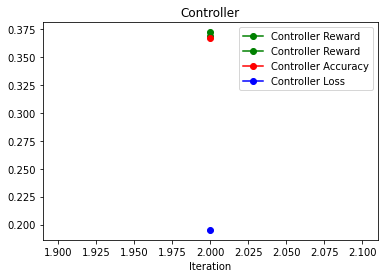

Here are 10 architectures:
[2]
[2 0]
[0 1 1]
[0 0 0 0]
[1 0 1 1 0]
[1 0 0 0 0 1]
[2 0 1 1 0 0 1]
[0 1 0 0 0 1 0 0]
[0 0 0 0 1 0 1 1 0]
[2 0 0 0 0 0 0 1 1 0]
[2 0 0 1 0 0 0 0 0 0 0]
[2 0 0 0 1 1 0 1 0 1 0 0]
val_acc=0.375
--------------------------------------------------------------------------------
[2]
[2 1]
[2 1 0]
[2 0 0 0]
[0 0 0 0 1]
[2 0 0 1 0 0]
[0 1 0 0 0 0 0]
[1 0 0 1 0 0 0 0]
[0 1 0 0 0 0 0 0 0]
[1 0 0 0 0 1 0 0 0 0]
[2 0 1 0 1 1 0 0 0 1 1]
[1 0 0 0 0 0 0 0 1 0 1 1]
val_acc=0.3984375
--------------------------------------------------------------------------------
[2]
[2 0]
[0 0 1]
[2 0 0 0]
[1 0 0 0 0]
[2 0 0 1 1 0]
[0 0 0 0 0 1 0]
[2 0 0 0 0 0 0 0]
[2 0 0 0 1 0 0 0 1]
[0 1 0 0 0 0 0 0 0 1]
[2 0 0 1 0 1 1 0 0 0 0]
[2 0 0 0 0 0 0 0 0 1 0 0]
val_acc=0.375
--------------------------------------------------------------------------------
[0]
[1 0]
[2 1 0]
[2 1 0 0]
[2 0 1 0 0]
[0 1 0 0 0 0]
[1 0 0 0 0 1 0]
[1 1 1 0 1 0 0 1]
[1 1 1 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0

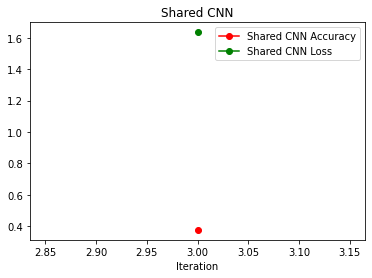

Epoch 3: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=1.532	ent=51.64	lr=0.0010	|g|=0.0194	acc=0.4141	bl=0.39	time=2.46it/s
ctrl_step=3	loss=-1.120	ent=50.36	lr=0.0010	|g|=0.0704	acc=0.3672	bl=0.39	time=2.41it/s
ctrl_step=5	loss=1.072	ent=51.58	lr=0.0010	|g|=0.1168	acc=0.4141	bl=0.40	time=2.50it/s
ctrl_step=7	loss=3.449	ent=50.62	lr=0.0010	|g|=0.0468	acc=0.4688	bl=0.40	time=2.71it/s
ctrl_step=9	loss=-1.043	ent=49.61	lr=0.0010	|g|=0.1343	acc=0.3750	bl=0.40	time=2.45it/s
ctrl_step=11	loss=-1.731	ent=49.38	lr=0.0010	|g|=0.1530	acc=0.3672	bl=0.40	time=2.75it/s
ctrl_step=13	loss=0.310	ent=51.58	lr=0.0010	|g|=0.0781	acc=0.4062	bl=0.40	time=2.66it/s
ctrl_step=15	loss=-2.982	ent=51.50	lr=0.0010	|g|=0.1615	acc=0.3438	bl=0.40	time=2.43it/s
ctrl_step=17	loss=-0.452	ent=49.00	lr=0.0010	|g|=0.2599	acc=0.3906	bl=0.40	time=2.63it/s
ctrl_step=19	loss=1.331	ent=49.38	lr=0.0010	|g|=0.2878	acc=0.4219	bl=0.40	time=2.59it/s


Traceback (most recent call last):


ctrl_step=21	loss=-3.009	ent=51.28	lr=0.0010	|g|=0.2809	acc=0.3438	bl=0.41	time=2.45it/s
ctrl_step=23	loss=-0.030	ent=49.01	lr=0.0010	|g|=0.1564	acc=0.3984	bl=0.40	time=2.66it/s
ctrl_step=25	loss=0.228	ent=49.24	lr=0.0010	|g|=0.1717	acc=0.4062	bl=0.41	time=2.43it/s
ctrl_step=27	loss=3.571	ent=49.12	lr=0.0010	|g|=0.1665	acc=0.4766	bl=0.41	time=2.41it/s
ctrl_step=29	loss=1.655	ent=49.28	lr=0.0010	|g|=0.2209	acc=0.4375	bl=0.41	time=2.58it/s
ctrl_step=31	loss=0.059	ent=49.66	lr=0.0010	|g|=0.0619	acc=0.4062	bl=0.41	time=2.55it/s
ctrl_step=33	loss=-2.990	ent=49.64	lr=0.0010	|g|=0.1323	acc=0.3438	bl=0.41	time=2.51it/s
ctrl_step=35	loss=-3.123	ent=49.12	lr=0.0010	|g|=0.0727	acc=0.3438	bl=0.41	time=2.32it/s
ctrl_step=37	loss=1.334	ent=50.11	lr=0.0010	|g|=0.0462	acc=0.4297	bl=0.41	time=2.54it/s
ctrl_step=39	loss=2.931	ent=50.18	lr=0.0010	|g|=0.0536	acc=0.4609	bl=0.41	time=2.52it/s


Traceback (most recent call last):


ctrl_step=41	loss=-1.122	ent=48.63	lr=0.0010	|g|=0.0958	acc=0.3828	bl=0.41	time=2.39it/s


Traceback (most recent call last):


ctrl_step=43	loss=-0.034	ent=49.30	lr=0.0010	|g|=0.1149	acc=0.3984	bl=0.40	time=2.36it/s
ctrl_step=45	loss=2.590	ent=47.54	lr=0.0010	|g|=0.1690	acc=0.4531	bl=0.41	time=2.49it/s
ctrl_step=47	loss=1.206	ent=47.22	lr=0.0010	|g|=0.2843	acc=0.4219	bl=0.40	time=2.31it/s
ctrl_step=49	loss=0.188	ent=48.53	lr=0.0010	|g|=0.0356	acc=0.4062	bl=0.41	time=2.35it/s


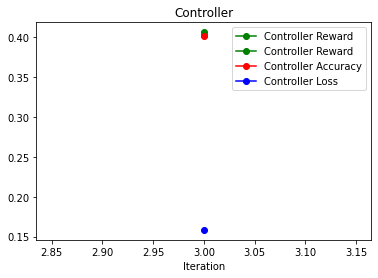

Here are 10 architectures:
[0]
[0 0]
[1 0 1]
[2 1 0 1]
[2 1 0 0 0]
[2 1 1 1 1 0]
[1 0 1 0 0 1 0]
[2 1 0 1 0 0 0 1]
[2 1 0 0 0 0 1 0 0]
[2 1 0 1 0 0 0 0 0 0]
[2 0 1 0 0 0 0 0 0 0 0]
[2 0 0 0 0 0 1 0 0 0 0 0]
val_acc=0.4609375
--------------------------------------------------------------------------------
[1]
[2 0]
[0 1 0]
[2 0 1 0]
[0 0 0 1 1]
[2 1 0 0 0 0]
[2 0 0 0 0 0 0]
[2 0 1 0 0 0 0 1]
[2 0 0 0 1 1 0 0 0]
[2 0 0 0 0 1 0 0 0 0]
[2 0 0 1 0 0 1 0 0 0 0]
[2 0 0 0 0 1 0 1 1 0 0 0]
val_acc=0.40625
--------------------------------------------------------------------------------
[2]
[1 1]
[2 1 1]
[2 0 0 0]
[2 0 0 1 0]
[2 0 0 0 0 0]
[0 0 0 0 1 0 0]
[2 1 0 1 0 0 1 0]
[2 0 0 0 0 0 0 0 0]
[2 1 1 1 0 0 0 0 0 0]
[2 0 0 0 1 0 1 0 1 0 0]
[0 0 0 0 0 0 1 1 0 0 0 0]
val_acc=0.40625
--------------------------------------------------------------------------------
[1]
[2 1]
[0 1 0]
[0 1 0 0]
[2 1 0 1 0]
[2 0 1 0 0 1]
[2 1 1 0 0 1 0]
[0 0 0 1 0 1 1 0]
[2 0 0 0 1 1 0 1 0]
[2 0 0 0 1 0 0 0 0 1]
[2 0 1 1 0

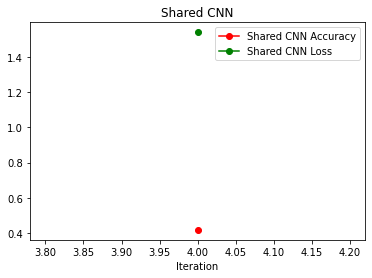

Epoch 4: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=1.145	ent=50.03	lr=0.0010	|g|=0.2320	acc=0.4375	bl=0.42	time=2.32it/s


Traceback (most recent call last):


ctrl_step=3	loss=-1.487	ent=47.27	lr=0.0010	|g|=0.1742	acc=0.3828	bl=0.42	time=2.26it/s
ctrl_step=5	loss=0.637	ent=48.59	lr=0.0010	|g|=0.1155	acc=0.4297	bl=0.42	time=2.46it/s
ctrl_step=7	loss=3.211	ent=49.27	lr=0.0010	|g|=0.1737	acc=0.4844	bl=0.43	time=2.29it/s
ctrl_step=9	loss=-1.000	ent=48.62	lr=0.0010	|g|=0.0606	acc=0.4062	bl=0.43	time=2.23it/s
ctrl_step=11	loss=3.132	ent=47.13	lr=0.0010	|g|=0.1247	acc=0.4844	bl=0.43	time=2.51it/s
ctrl_step=13	loss=-0.327	ent=48.54	lr=0.0010	|g|=0.0417	acc=0.4219	bl=0.43	time=2.24it/s
ctrl_step=15	loss=0.985	ent=47.10	lr=0.0010	|g|=0.1780	acc=0.4531	bl=0.44	time=2.23it/s
ctrl_step=17	loss=0.347	ent=49.06	lr=0.0010	|g|=0.2281	acc=0.4375	bl=0.44	time=2.19it/s
ctrl_step=19	loss=-0.404	ent=46.34	lr=0.0010	|g|=0.0741	acc=0.4219	bl=0.43	time=2.40it/s
ctrl_step=21	loss=-2.758	ent=49.08	lr=0.0010	|g|=0.1023	acc=0.3750	bl=0.44	time=2.42it/s
ctrl_step=23	loss=-1.757	ent=45.65	lr=0.0010	|g|=0.1327	acc=0.3828	bl=0.43	time=2.21it/s
ctrl_step=25	loss=0.790	ent=48

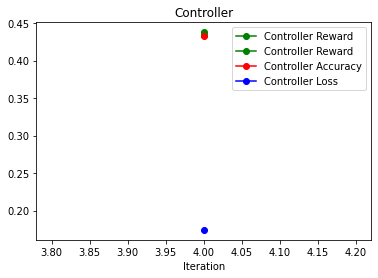

Here are 10 architectures:
[0]
[2 0]
[2 1 0]
[2 1 0 0]
[2 1 0 0 0]
[2 0 1 0 1 0]
[2 1 0 0 1 0 0]
[2 0 0 1 0 1 1 1]
[2 0 0 0 1 0 0 0 1]
[2 0 0 1 1 1 1 1 0 0]
[2 0 0 0 0 1 0 0 1 1 1]
[0 1 1 0 0 0 1 1 1 1 0 0]
val_acc=0.4140625
--------------------------------------------------------------------------------
[1]
[2 0]
[2 0 0]
[2 1 0 1]
[2 0 1 1 0]
[2 0 1 0 0 0]
[2 0 0 1 1 0 0]
[2 0 0 0 0 0 0 0]
[2 0 0 0 1 0 0 0 0]
[2 1 0 0 0 0 0 1 0 0]
[2 0 1 0 0 0 0 0 0 0 1]
[1 0 1 1 1 1 0 0 1 0 0 1]
val_acc=0.484375
--------------------------------------------------------------------------------
[2]
[0 0]
[2 0 1]
[2 0 0 1]
[2 0 0 0 0]
[2 0 1 1 0 0]
[2 0 1 0 1 0 1]
[2 1 0 0 1 0 1 0]
[0 0 1 0 0 0 1 0 1]
[2 0 1 0 0 0 0 0 0 0]
[2 1 1 0 0 0 1 0 0 1 0]
[1 1 0 0 0 0 0 0 1 0 0 1]
val_acc=0.53125
--------------------------------------------------------------------------------
[2]
[2 1]
[0 1 1]
[2 0 1 1]
[2 0 1 0 1]
[2 1 0 0 0 0]
[2 0 0 0 1 0 0]
[2 0 0 1 0 0 0 0]
[2 0 0 0 0 0 1 1 0]
[2 0 0 0 0 0 0 0 0 1]
[2 0 1 1 

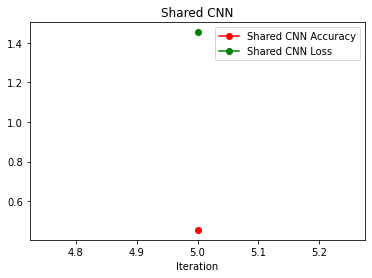

Epoch 5: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=3.895	ent=46.48	lr=0.0010	|g|=0.1192	acc=0.5469	bl=0.46	time=2.10it/s
ctrl_step=3	loss=1.206	ent=46.20	lr=0.0010	|g|=0.2072	acc=0.4922	bl=0.47	time=2.11it/s
ctrl_step=5	loss=1.480	ent=46.14	lr=0.0010	|g|=0.0845	acc=0.5078	bl=0.48	time=2.23it/s
ctrl_step=7	loss=1.953	ent=45.69	lr=0.0010	|g|=0.1398	acc=0.5156	bl=0.48	time=2.26it/s


Traceback (most recent call last):


ctrl_step=9	loss=-1.579	ent=44.84	lr=0.0010	|g|=0.2862	acc=0.4453	bl=0.48	time=2.04it/s
ctrl_step=11	loss=-1.508	ent=46.11	lr=0.0010	|g|=0.1482	acc=0.4453	bl=0.48	time=2.22it/s
ctrl_step=13	loss=-2.737	ent=44.09	lr=0.0010	|g|=0.3573	acc=0.4141	bl=0.48	time=2.23it/s
ctrl_step=15	loss=0.538	ent=44.55	lr=0.0010	|g|=0.0344	acc=0.4922	bl=0.49	time=2.09it/s


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)


ctrl_step=17	loss=-0.748	ent=48.14	lr=0.0010	|g|=0.2326	acc=0.4688	bl=0.49	time=2.10it/s
ctrl_step=19	loss=-1.808	ent=44.54	lr=0.0010	|g|=0.0678	acc=0.4453	bl=0.49	time=2.06it/s
ctrl_step=21	loss=2.218	ent=44.34	lr=0.0010	|g|=0.3419	acc=0.5312	bl=0.49	time=2.08it/s
ctrl_step=23	loss=1.374	ent=46.42	lr=0.0010	|g|=0.0625	acc=0.5078	bl=0.49	time=2.18it/s
ctrl_step=25	loss=1.886	ent=44.58	lr=0.0010	|g|=0.2263	acc=0.5234	bl=0.49	time=2.22it/s
ctrl_step=27	loss=-1.063	ent=43.43	lr=0.0010	|g|=0.0597	acc=0.4609	bl=0.49	time=2.21it/s
ctrl_step=29	loss=-2.889	ent=46.14	lr=0.0010	|g|=0.1665	acc=0.4141	bl=0.49	time=2.23it/s
ctrl_step=31	loss=6.758	ent=45.82	lr=0.0010	|g|=0.0996	acc=0.6328	bl=0.49	time=2.12it/s
ctrl_step=33	loss=3.323	ent=44.19	lr=0.0010	|g|=0.0399	acc=0.5625	bl=0.49	time=2.01it/s
ctrl_step=35	loss=-1.767	ent=44.66	lr=0.0010	|g|=0.1107	acc=0.4453	bl=0.49	time=2.03it/s
ctrl_step=37	loss=0.967	ent=42.89	lr=0.0010	|g|=0.0764	acc=0.5078	bl=0.49	time=2.02it/s
ctrl_step=39	loss=-2.064	en

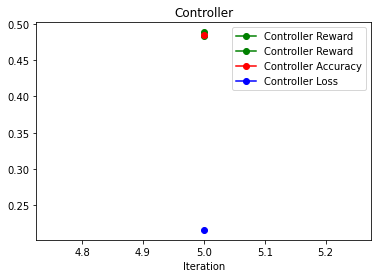

Here are 10 architectures:
[2]
[2 0]
[2 0 1]
[1 1 0 1]
[2 0 0 1 1]
[2 1 1 0 1 0]
[2 1 1 0 0 0 0]
[2 0 0 0 0 0 1 1]
[2 0 0 1 1 0 1 0 0]
[2 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0]
[2 1 0 0 1 1 0 0 0 0 0 0]
val_acc=0.453125
--------------------------------------------------------------------------------
[0]
[2 0]
[2 0 0]
[2 0 0 1]
[0 0 0 0 1]
[2 0 1 0 0 0]
[2 1 1 0 1 0 0]
[2 0 1 0 0 0 0 0]
[2 0 0 0 0 1 0 0 0]
[2 0 1 0 0 0 0 0 1 0]
[2 1 0 0 0 1 0 0 0 0 0]
[0 0 0 0 1 0 1 1 0 0 1 1]
val_acc=0.4921875
--------------------------------------------------------------------------------
[2]
[2 0]
[2 1 1]
[2 0 0 0]
[2 0 1 0 0]
[1 1 0 1 0 0]
[2 0 0 0 0 0 0]
[2 0 1 0 0 0 0 1]
[2 0 0 0 0 1 0 1 0]
[2 0 0 0 0 1 0 1 0 1]
[2 0 0 0 0 0 0 0 0 0 0]
[2 0 1 0 0 1 1 0 0 0 1 1]
val_acc=0.40625
--------------------------------------------------------------------------------
[2]
[1 0]
[2 0 1]
[2 0 0 0]
[2 0 0 1 0]
[2 0 0 0 0 1]
[2 1 0 0 0 0 1]
[2 1 0 1 0 0 0 0]
[2 0 1 0 0 0 0 0 1]
[2 1 0 1 1 1 0 0 1 0]
[2 1 1 0 

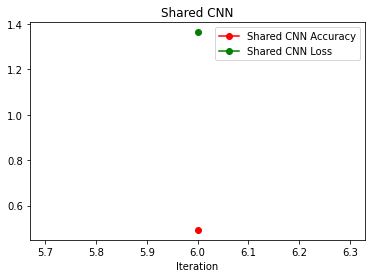

Epoch 6: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=1.817	ent=40.73	lr=0.0010	|g|=0.0860	acc=0.5469	bl=0.50	time=1.93it/s
ctrl_step=3	loss=0.052	ent=44.68	lr=0.0010	|g|=0.2512	acc=0.5000	bl=0.50	time=2.20it/s
ctrl_step=5	loss=0.438	ent=42.77	lr=0.0010	|g|=0.0530	acc=0.5156	bl=0.51	time=1.93it/s
ctrl_step=7	loss=-0.384	ent=41.47	lr=0.0010	|g|=0.0939	acc=0.4922	bl=0.51	time=2.05it/s
ctrl_step=9	loss=-2.481	ent=45.35	lr=0.0010	|g|=0.3872	acc=0.4531	bl=0.51	time=2.10it/s
ctrl_step=11	loss=1.171	ent=43.21	lr=0.0010	|g|=0.2454	acc=0.5312	bl=0.51	time=2.10it/s
ctrl_step=13	loss=2.695	ent=46.05	lr=0.0010	|g|=0.3289	acc=0.5703	bl=0.51	time=2.06it/s
ctrl_step=15	loss=4.922	ent=45.51	lr=0.0010	|g|=0.1093	acc=0.6172	bl=0.51	time=1.91it/s
ctrl_step=17	loss=-1.358	ent=45.09	lr=0.0010	|g|=0.0347	acc=0.4766	bl=0.52	time=1.92it/s
ctrl_step=19	loss=-0.302	ent=41.50	lr=0.0010	|g|=0.5053	acc=0.5078	bl=0.52	time=2.04it/s
ctrl_step=21	loss=1.412	ent=44.33	lr=0.0010	|g|=0.0374	acc=0.5391	bl=0.52	time=1.97it/s
ctrl_step=23	loss=0.362	ent=43.62

Traceback (most recent call last):


ctrl_step=49	loss=-3.955	ent=42.65	lr=0.0010	|g|=0.1186	acc=0.4375	bl=0.52	time=1.92it/s


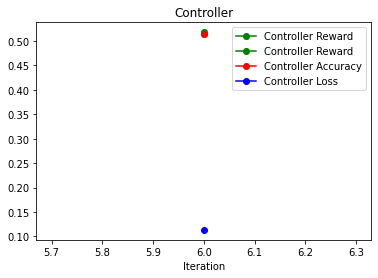

Here are 10 architectures:
[0]
[2 1]
[2 1 0]
[2 0 0 1]
[2 0 0 1 0]
[0 0 0 1 1 0]
[2 0 1 1 0 0 1]
[1 1 0 0 0 0 0 0]
[2 0 0 0 0 1 0 1 1]
[2 0 0 1 0 0 1 0 0 1]
[2 0 0 1 0 0 0 0 0 0 1]
[2 0 0 0 1 0 0 0 0 1 0 1]
val_acc=0.4609375
--------------------------------------------------------------------------------
[2]
[2 0]
[2 0 1]
[2 0 1 1]
[1 0 0 0 1]
[2 0 0 0 0 0]
[2 1 0 0 0 0 0]
[2 1 0 1 0 0 1 0]
[2 0 1 0 0 1 1 0 0]
[2 0 0 0 1 0 0 0 0 1]
[2 0 0 0 1 0 0 0 0 0 1]
[0 0 1 0 1 1 0 0 1 0 1 1]
val_acc=0.4765625
--------------------------------------------------------------------------------
[2]
[2 0]
[2 0 1]
[2 1 0 0]
[2 1 0 1 0]
[2 0 1 0 1 1]
[2 1 1 0 1 0 0]
[2 1 0 0 1 1 0 0]
[2 1 0 0 0 1 0 0 0]
[2 0 1 0 0 1 0 1 0 1]
[2 0 1 0 0 0 0 0 0 0 0]
[2 0 0 0 0 1 1 0 0 0 0 0]
val_acc=0.4921875
--------------------------------------------------------------------------------
[2]
[2 0]
[2 0 1]
[2 0 1 0]
[2 0 0 1 1]
[2 0 1 1 0 1]
[2 1 0 0 0 0 0]
[2 1 1 0 1 0 0 0]
[2 1 0 0 0 0 0 0 0]
[2 0 0 0 0 0 0 0 0 0]
[2 0 1

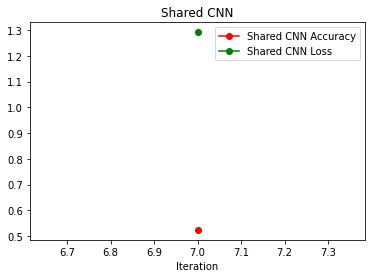

Epoch 7: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=0.098	ent=43.88	lr=0.0010	|g|=0.0591	acc=0.5234	bl=0.53	time=1.96it/s
ctrl_step=3	loss=-2.828	ent=43.41	lr=0.0010	|g|=0.0914	acc=0.4609	bl=0.52	time=1.92it/s
ctrl_step=5	loss=-3.018	ent=45.21	lr=0.0010	|g|=0.0393	acc=0.4609	bl=0.53	time=1.84it/s
ctrl_step=7	loss=2.657	ent=42.60	lr=0.0010	|g|=0.0526	acc=0.5859	bl=0.53	time=1.81it/s
ctrl_step=9	loss=-3.358	ent=39.40	lr=0.0010	|g|=0.5651	acc=0.4141	bl=0.53	time=1.96it/s


Traceback (most recent call last):


ctrl_step=11	loss=2.904	ent=43.86	lr=0.0010	|g|=0.2906	acc=0.5938	bl=0.53	time=1.97it/s
ctrl_step=13	loss=1.055	ent=42.99	lr=0.0010	|g|=0.1958	acc=0.5547	bl=0.54	time=1.79it/s
ctrl_step=15	loss=1.427	ent=45.37	lr=0.0010	|g|=0.2277	acc=0.5625	bl=0.54	time=1.90it/s
ctrl_step=17	loss=-3.618	ent=39.93	lr=0.0010	|g|=0.5807	acc=0.4219	bl=0.53	time=1.78it/s


Traceback (most recent call last):


ctrl_step=19	loss=0.678	ent=45.11	lr=0.0010	|g|=0.1443	acc=0.5391	bl=0.53	time=1.87it/s
ctrl_step=21	loss=-2.290	ent=44.40	lr=0.0010	|g|=0.1952	acc=0.4766	bl=0.53	time=1.95it/s
ctrl_step=23	loss=1.291	ent=42.47	lr=0.0010	|g|=0.0282	acc=0.5625	bl=0.53	time=1.81it/s
ctrl_step=25	loss=1.205	ent=45.01	lr=0.0010	|g|=0.2321	acc=0.5547	bl=0.53	time=1.79it/s
ctrl_step=27	loss=-0.614	ent=43.50	lr=0.0010	|g|=0.1077	acc=0.5156	bl=0.53	time=1.92it/s
ctrl_step=29	loss=0.536	ent=38.07	lr=0.0010	|g|=0.6141	acc=0.5469	bl=0.53	time=1.84it/s
ctrl_step=31	loss=0.649	ent=45.19	lr=0.0010	|g|=0.0344	acc=0.5469	bl=0.54	time=1.92it/s
ctrl_step=33	loss=3.189	ent=41.98	lr=0.0010	|g|=0.0669	acc=0.6172	bl=0.54	time=1.80it/s
ctrl_step=35	loss=0.700	ent=43.07	lr=0.0010	|g|=0.1489	acc=0.5469	bl=0.54	time=1.74it/s
ctrl_step=37	loss=1.193	ent=43.71	lr=0.0010	|g|=0.0931	acc=0.5625	bl=0.54	time=1.86it/s


Traceback (most recent call last):


ctrl_step=39	loss=-1.961	ent=42.56	lr=0.0010	|g|=0.1415	acc=0.4844	bl=0.53	time=1.78it/s
ctrl_step=41	loss=1.815	ent=43.30	lr=0.0010	|g|=0.0466	acc=0.5703	bl=0.53	time=1.81it/s
ctrl_step=43	loss=0.809	ent=43.04	lr=0.0010	|g|=0.2377	acc=0.5469	bl=0.53	time=1.86it/s
ctrl_step=45	loss=-0.297	ent=43.55	lr=0.0010	|g|=0.1859	acc=0.5234	bl=0.54	time=1.81it/s
ctrl_step=47	loss=2.082	ent=44.64	lr=0.0010	|g|=0.0990	acc=0.5781	bl=0.53	time=1.88it/s
ctrl_step=49	loss=-3.385	ent=43.93	lr=0.0010	|g|=0.2080	acc=0.4609	bl=0.53	time=1.86it/s


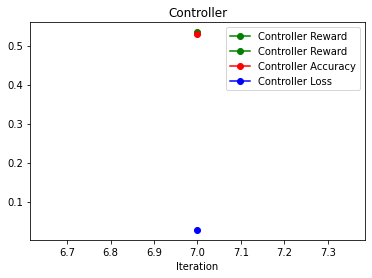

Here are 10 architectures:
[2]
[0 1]
[2 1 0]
[2 0 0 0]
[2 0 0 0 0]
[2 0 0 0 0 0]
[1 0 0 1 1 0 0]
[2 0 0 0 0 0 0 0]
[2 0 1 0 0 1 0 0 0]
[2 0 0 0 0 0 0 1 1 0]
[2 0 0 0 0 0 1 0 1 1 0]
[0 0 0 0 0 0 0 0 1 0 0 0]
val_acc=0.484375
--------------------------------------------------------------------------------
[1]
[2 1]
[2 0 1]
[2 1 0 1]
[2 0 0 1 0]
[2 0 0 1 0 0]
[2 0 1 0 1 1 1]
[2 0 0 0 0 0 1 0]
[2 0 0 0 0 0 0 0 0]
[2 0 0 0 1 0 1 1 0 1]
[2 0 1 0 1 0 0 0 0 0 0]
[2 0 0 0 0 1 1 0 1 0 0 0]
val_acc=0.4765625
--------------------------------------------------------------------------------
[2]
[2 1]
[2 1 0]
[2 0 0 0]
[2 0 0 1 0]
[2 1 0 1 1 1]
[2 1 0 0 0 1 0]
[2 0 1 1 0 0 1 0]
[2 0 0 1 0 0 0 0 0]
[2 1 0 1 0 0 0 0 0 0]
[2 0 0 0 0 0 0 0 0 0 0]
[2 0 1 0 0 1 0 0 0 0 1 1]
val_acc=0.609375
--------------------------------------------------------------------------------
[0]
[2 0]
[2 0 1]
[2 0 1 0]
[2 0 1 0 0]
[2 1 0 0 1 0]
[0 1 1 1 0 1 0]
[2 1 0 1 0 0 0 0]
[2 0 0 0 0 0 0 0 0]
[2 0 0 0 0 0 0 1 0 0]
[1 1 0 0

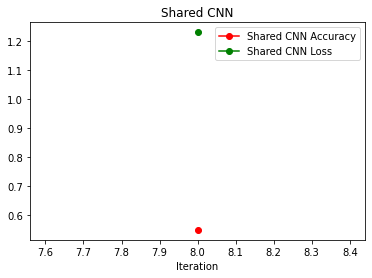

Epoch 8: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=-0.607	ent=41.94	lr=0.0010	|g|=0.1751	acc=0.5156	bl=0.53	time=1.69it/s
ctrl_step=3	loss=1.133	ent=43.43	lr=0.0010	|g|=0.0649	acc=0.5703	bl=0.55	time=1.67it/s
ctrl_step=5	loss=-2.625	ent=41.34	lr=0.0010	|g|=0.1860	acc=0.4844	bl=0.55	time=1.84it/s
ctrl_step=7	loss=0.994	ent=43.70	lr=0.0010	|g|=0.2633	acc=0.5781	bl=0.56	time=1.75it/s
ctrl_step=9	loss=-1.854	ent=41.01	lr=0.0010	|g|=0.1284	acc=0.5078	bl=0.56	time=1.84it/s
ctrl_step=11	loss=2.586	ent=43.92	lr=0.0010	|g|=0.1289	acc=0.6250	bl=0.56	time=1.68it/s
ctrl_step=13	loss=-0.866	ent=42.52	lr=0.0010	|g|=0.0487	acc=0.5312	bl=0.56	time=1.80it/s
ctrl_step=15	loss=-0.091	ent=45.16	lr=0.0010	|g|=0.0177	acc=0.5469	bl=0.55	time=1.69it/s
ctrl_step=17	loss=3.567	ent=40.84	lr=0.0010	|g|=0.1238	acc=0.6484	bl=0.56	time=1.76it/s
ctrl_step=19	loss=-1.290	ent=43.46	lr=0.0010	|g|=0.1108	acc=0.5234	bl=0.56	time=1.81it/s
ctrl_step=21	loss=-0.456	ent=42.54	lr=0.0010	|g|=0.1542	acc=0.5469	bl=0.56	time=1.73it/s
ctrl_step=23	loss=1.225	ent=43

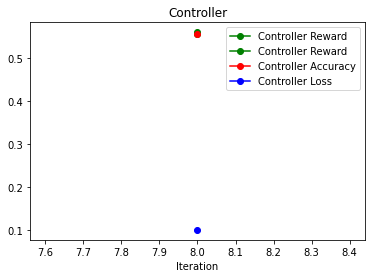

Here are 10 architectures:
[0]
[2 0]
[2 1 1]
[2 0 1 0]
[2 0 0 1 1]
[2 0 1 0 0 0]
[2 0 1 0 0 1 0]
[2 1 1 0 0 1 0 0]
[2 0 0 1 0 0 1 0 1]
[2 0 0 0 0 0 0 0 1 0]
[2 1 1 1 1 0 0 0 0 0 0]
[2 0 0 0 0 1 0 0 0 0 1 0]
val_acc=0.5625
--------------------------------------------------------------------------------
[2]
[2 1]
[2 0 0]
[2 0 0 0]
[2 0 0 0 0]
[2 0 0 0 0 1]
[2 0 1 1 1 1 0]
[2 0 1 0 0 0 1 0]
[2 1 0 0 0 0 1 0 0]
[2 0 1 0 0 1 0 0 1 0]
[2 0 0 0 1 0 0 0 0 1 1]
[2 0 0 0 1 0 0 1 0 0 0 1]
val_acc=0.640625
--------------------------------------------------------------------------------
[2]
[2 0]
[2 1 1]
[2 1 1 0]
[2 0 0 1 0]
[2 1 0 1 0 1]
[2 0 0 0 1 1 1]
[2 1 0 0 0 1 0 0]
[2 1 0 1 0 0 0 1 0]
[2 1 0 1 0 1 1 0 1 0]
[2 1 0 0 0 0 1 0 1 1 0]
[2 0 0 0 0 0 0 0 0 0 1 0]
val_acc=0.640625
--------------------------------------------------------------------------------
[1]
[2 1]
[2 0 1]
[2 0 0 0]
[2 0 0 0 0]
[2 1 0 0 0 1]
[1 0 0 0 0 1 0]
[2 0 0 1 1 1 0 1]
[2 0 0 0 0 1 0 0 1]
[2 1 0 0 0 1 1 1 1 1]
[0 1 0 0 0 

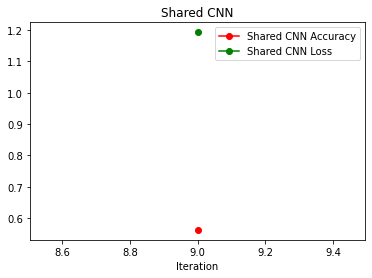

Epoch 9: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=-0.407	ent=46.40	lr=0.0010	|g|=0.3768	acc=0.5547	bl=0.57	time=1.61it/s
ctrl_step=3	loss=-0.905	ent=40.87	lr=0.0010	|g|=0.4401	acc=0.5469	bl=0.57	time=1.66it/s
ctrl_step=5	loss=1.290	ent=42.00	lr=0.0010	|g|=0.1163	acc=0.5938	bl=0.57	time=1.60it/s
ctrl_step=7	loss=2.457	ent=44.45	lr=0.0010	|g|=0.2933	acc=0.6172	bl=0.57	time=1.74it/s
ctrl_step=9	loss=-1.895	ent=41.87	lr=0.0010	|g|=0.0872	acc=0.5234	bl=0.58	time=1.65it/s
ctrl_step=11	loss=-2.446	ent=41.23	lr=0.0010	|g|=0.3932	acc=0.5078	bl=0.57	time=1.64it/s
ctrl_step=13	loss=-0.303	ent=43.88	lr=0.0010	|g|=0.1116	acc=0.5625	bl=0.58	time=1.68it/s
ctrl_step=15	loss=-0.205	ent=44.44	lr=0.0010	|g|=0.2561	acc=0.5625	bl=0.57	time=1.58it/s
ctrl_step=17	loss=1.656	ent=42.99	lr=0.0010	|g|=0.0765	acc=0.6016	bl=0.57	time=1.57it/s
ctrl_step=19	loss=1.244	ent=41.96	lr=0.0010	|g|=0.0152	acc=0.5938	bl=0.57	time=1.60it/s
ctrl_step=21	loss=0.205	ent=44.28	lr=0.0010	|g|=0.1563	acc=0.5703	bl=0.57	time=1.59it/s
ctrl_step=23	loss=-1.082	ent=43

Traceback (most recent call last):


ctrl_step=27	loss=2.763	ent=43.08	lr=0.0010	|g|=0.1072	acc=0.6328	bl=0.57	time=1.50it/s
ctrl_step=29	loss=-0.099	ent=43.09	lr=0.0010	|g|=0.0161	acc=0.5625	bl=0.57	time=1.60it/s
ctrl_step=31	loss=4.824	ent=42.21	lr=0.0010	|g|=0.1179	acc=0.6875	bl=0.57	time=1.61it/s
ctrl_step=33	loss=0.042	ent=40.89	lr=0.0010	|g|=0.2002	acc=0.5703	bl=0.57	time=1.66it/s
ctrl_step=35	loss=1.080	ent=43.68	lr=0.0010	|g|=0.0446	acc=0.6016	bl=0.58	time=1.61it/s
ctrl_step=37	loss=-1.528	ent=41.28	lr=0.0010	|g|=0.1275	acc=0.5391	bl=0.58	time=1.71it/s
ctrl_step=39	loss=1.536	ent=43.46	lr=0.0010	|g|=0.0273	acc=0.6094	bl=0.58	time=1.68it/s
ctrl_step=41	loss=4.154	ent=44.12	lr=0.0010	|g|=0.1182	acc=0.6797	bl=0.58	time=1.51it/s
ctrl_step=43	loss=-3.854	ent=42.51	lr=0.0010	|g|=0.2401	acc=0.5000	bl=0.58	time=1.54it/s
ctrl_step=45	loss=2.995	ent=38.49	lr=0.0010	|g|=0.5971	acc=0.6562	bl=0.58	time=1.62it/s
ctrl_step=47	loss=-0.393	ent=39.96	lr=0.0010	|g|=0.1730	acc=0.5625	bl=0.58	time=1.65it/s
ctrl_step=49	loss=-2.799	ent

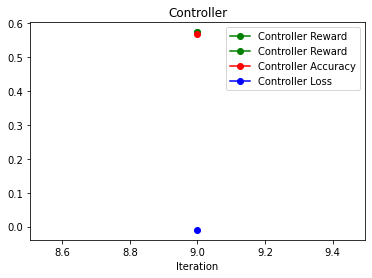

Here are 10 architectures:
[2]
[2 0]
[2 0 0]
[2 0 1 1]
[0 0 1 0 0]
[2 0 1 1 0 0]
[2 1 1 0 0 0 0]
[2 0 0 0 0 0 0 0]
[2 1 0 0 1 0 0 0 0]
[2 1 0 0 0 1 0 0 0 0]
[2 1 0 1 0 0 1 1 0 1 0]
[2 1 0 0 0 1 0 1 0 1 0 0]
val_acc=0.609375
--------------------------------------------------------------------------------
[2]
[2 0]
[2 1 0]
[2 0 0 1]
[2 1 0 0 1]
[2 0 0 0 0 1]
[2 0 0 1 0 1 0]
[2 0 0 0 1 0 0 0]
[2 0 0 0 0 0 0 0 1]
[2 0 0 1 0 1 1 0 0 1]
[2 0 0 1 0 0 1 1 0 1 0]
[2 0 0 0 0 0 1 1 1 0 0 0]
val_acc=0.6640625
--------------------------------------------------------------------------------
[2]
[2 1]
[2 0 0]
[2 0 0 0]
[0 0 0 1 0]
[1 0 0 0 1 1]
[2 0 0 0 1 0 0]
[2 0 0 0 0 1 0 0]
[0 0 0 0 1 0 0 0 0]
[2 0 1 0 0 1 0 1 0 1]
[2 0 1 1 1 1 0 1 0 0 0]
[2 0 0 0 0 0 0 0 0 0 0 0]
val_acc=0.6328125
--------------------------------------------------------------------------------
[2]
[2 1]
[2 1 0]
[2 1 0 1]
[2 0 0 1 1]
[2 0 1 1 0 1]
[2 0 1 1 0 0 0]
[2 1 1 1 0 0 0 0]
[1 1 0 1 0 0 0 1 0]
[2 1 0 0 1 0 0 0 1 0]
[2 0 0 

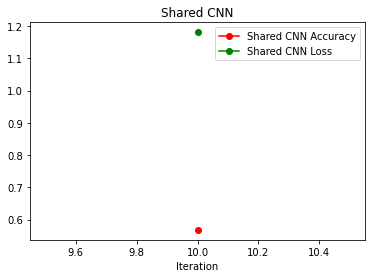

Epoch 10: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=0.936	ent=42.43	lr=0.0010	|g|=0.0823	acc=0.5938	bl=0.57	time=1.58it/s
ctrl_step=3	loss=-2.301	ent=44.43	lr=0.0010	|g|=0.0719	acc=0.5156	bl=0.57	time=1.55it/s
ctrl_step=5	loss=0.212	ent=42.23	lr=0.0010	|g|=0.0635	acc=0.5781	bl=0.58	time=1.60it/s


Traceback (most recent call last):


ctrl_step=7	loss=-1.936	ent=43.51	lr=0.0010	|g|=0.2303	acc=0.5391	bl=0.58	time=1.60it/s
ctrl_step=9	loss=0.729	ent=43.54	lr=0.0010	|g|=0.1749	acc=0.5938	bl=0.58	time=1.48it/s
ctrl_step=11	loss=0.715	ent=45.03	lr=0.0010	|g|=0.1102	acc=0.5938	bl=0.58	time=1.59it/s
ctrl_step=13	loss=-3.323	ent=42.01	lr=0.0010	|g|=0.0839	acc=0.5000	bl=0.58	time=1.57it/s
ctrl_step=15	loss=-0.130	ent=40.82	lr=0.0010	|g|=0.0967	acc=0.5703	bl=0.58	time=1.60it/s
ctrl_step=17	loss=-0.633	ent=44.29	lr=0.0010	|g|=0.3103	acc=0.5625	bl=0.58	time=1.55it/s
ctrl_step=19	loss=3.064	ent=42.91	lr=0.0010	|g|=0.0221	acc=0.6484	bl=0.58	time=1.61it/s
ctrl_step=21	loss=-2.269	ent=42.47	lr=0.0010	|g|=0.0541	acc=0.5156	bl=0.58	time=1.56it/s
ctrl_step=23	loss=1.968	ent=43.66	lr=0.0010	|g|=0.0830	acc=0.6172	bl=0.58	time=1.48it/s
ctrl_step=25	loss=0.758	ent=41.66	lr=0.0010	|g|=0.4348	acc=0.5938	bl=0.58	time=1.48it/s
ctrl_step=27	loss=1.924	ent=44.51	lr=0.0010	|g|=0.1371	acc=0.6250	bl=0.58	time=1.53it/s
ctrl_step=29	loss=-3.515	ent=

Traceback (most recent call last):


ctrl_step=37	loss=-2.341	ent=43.20	lr=0.0010	|g|=0.1702	acc=0.5234	bl=0.58	time=1.51it/s
ctrl_step=39	loss=1.178	ent=41.07	lr=0.0010	|g|=0.5445	acc=0.6016	bl=0.58	time=1.48it/s
ctrl_step=41	loss=0.653	ent=43.82	lr=0.0010	|g|=0.0791	acc=0.5859	bl=0.58	time=1.45it/s
ctrl_step=43	loss=-0.848	ent=40.89	lr=0.0010	|g|=0.1646	acc=0.5469	bl=0.58	time=1.53it/s
ctrl_step=45	loss=-1.205	ent=45.10	lr=0.0010	|g|=0.3224	acc=0.5391	bl=0.57	time=1.56it/s
ctrl_step=47	loss=3.204	ent=42.95	lr=0.0010	|g|=0.1027	acc=0.6562	bl=0.58	time=1.52it/s
ctrl_step=49	loss=-0.086	ent=41.72	lr=0.0010	|g|=0.2642	acc=0.5703	bl=0.58	time=1.43it/s


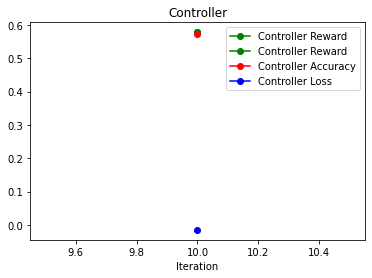

Here are 10 architectures:
[2]
[2 0]
[2 0 1]
[2 0 0 0]
[2 0 0 0 0]
[2 0 0 1 1 0]
[2 1 0 0 0 0 1]
[2 0 0 1 0 1 0 0]
[2 0 0 0 1 0 1 0 0]
[2 1 0 0 0 0 0 0 0 1]
[2 1 0 0 1 0 1 0 0 0 0]
[2 0 0 0 0 0 0 0 0 1 0 1]
val_acc=0.65625
--------------------------------------------------------------------------------
[2]
[2 0]
[0 0 0]
[2 0 0 1]
[0 1 1 0 0]
[2 0 1 0 0 1]
[2 0 1 0 0 0 0]
[2 0 0 0 1 0 0 1]
[1 0 0 1 0 0 0 0 0]
[2 0 0 0 0 1 0 1 0 0]
[2 1 0 1 1 0 1 1 0 0 1]
[2 1 0 1 1 0 0 1 0 0 0 1]
val_acc=0.6484375
--------------------------------------------------------------------------------
[2]
[2 0]
[2 0 1]
[2 0 0 0]
[2 0 0 0 1]
[2 0 0 0 0 0]
[2 0 1 0 0 0 0]
[2 0 1 0 0 1 1 1]
[2 0 0 0 1 1 0 0 0]
[2 0 0 0 0 1 0 1 0 0]
[2 1 0 1 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 1 0 1]
val_acc=0.6015625
--------------------------------------------------------------------------------
[2]
[2 0]
[2 1 0]
[2 1 0 1]
[2 0 0 0 0]
[2 0 0 1 1 0]
[2 1 0 0 0 1 0]
[2 1 1 0 1 0 0 0]
[2 0 0 0 0 0 0 0 0]
[2 0 0 1 0 0 0 0 0 0]
[2 0 0 0

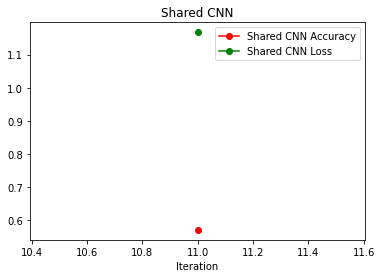

Epoch 11: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=-2.491	ent=43.09	lr=0.0010	|g|=0.0229	acc=0.5156	bl=0.58	time=1.50it/s
ctrl_step=3	loss=0.046	ent=43.01	lr=0.0010	|g|=0.0418	acc=0.5703	bl=0.57	time=1.42it/s
ctrl_step=5	loss=0.750	ent=43.76	lr=0.0010	|g|=0.3073	acc=0.5859	bl=0.57	time=1.50it/s


Traceback (most recent call last):


ctrl_step=7	loss=4.646	ent=42.93	lr=0.0010	|g|=0.0142	acc=0.6719	bl=0.58	time=1.55it/s


Traceback (most recent call last):


ctrl_step=9	loss=2.228	ent=43.83	lr=0.0010	|g|=0.1524	acc=0.6328	bl=0.58	time=1.48it/s
ctrl_step=11	loss=-3.792	ent=44.10	lr=0.0010	|g|=0.2753	acc=0.5000	bl=0.58	time=1.47it/s
ctrl_step=13	loss=-1.934	ent=45.54	lr=0.0010	|g|=0.3822	acc=0.5312	bl=0.58	time=1.50it/s


Traceback (most recent call last):


ctrl_step=15	loss=-1.137	ent=41.83	lr=0.0010	|g|=0.1973	acc=0.5547	bl=0.59	time=1.50it/s
ctrl_step=17	loss=-1.331	ent=43.02	lr=0.0010	|g|=0.0537	acc=0.5469	bl=0.58	time=1.47it/s
ctrl_step=19	loss=-2.176	ent=42.41	lr=0.0010	|g|=0.1136	acc=0.5234	bl=0.58	time=1.40it/s
ctrl_step=21	loss=3.342	ent=43.36	lr=0.0010	|g|=0.0119	acc=0.6562	bl=0.58	time=1.51it/s
ctrl_step=23	loss=-1.654	ent=42.92	lr=0.0010	|g|=0.2548	acc=0.5391	bl=0.58	time=1.47it/s
ctrl_step=25	loss=-1.228	ent=45.20	lr=0.0010	|g|=0.4069	acc=0.5547	bl=0.58	time=1.54it/s
ctrl_step=27	loss=-1.934	ent=41.82	lr=0.0010	|g|=0.2700	acc=0.5234	bl=0.58	time=1.40it/s
ctrl_step=29	loss=-2.438	ent=41.34	lr=0.0010	|g|=0.0258	acc=0.5156	bl=0.58	time=1.48it/s
ctrl_step=31	loss=-3.301	ent=42.11	lr=0.0010	|g|=0.4895	acc=0.4844	bl=0.58	time=1.55it/s
ctrl_step=33	loss=1.891	ent=44.25	lr=0.0010	|g|=0.0980	acc=0.6172	bl=0.58	time=1.50it/s
ctrl_step=35	loss=0.437	ent=42.92	lr=0.0010	|g|=0.0388	acc=0.5859	bl=0.58	time=1.46it/s
ctrl_step=37	loss=2.702	

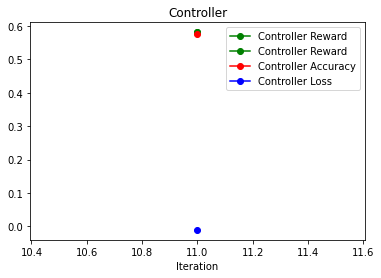

Here are 10 architectures:
[2]
[2 0]
[2 1 0]
[2 0 0 0]
[2 1 0 1 0]
[2 0 0 0 0 0]
[2 0 0 0 0 0 0]
[2 0 0 1 1 0 0 0]
[0 0 1 1 1 0 1 0 0]
[2 0 1 1 1 0 0 0 0 1]
[2 0 0 0 1 0 0 0 0 0 0]
[2 0 0 0 0 0 1 0 0 0 1 1]
val_acc=0.5859375
--------------------------------------------------------------------------------
[2]
[2 1]
[2 0 1]
[2 0 1 0]
[2 0 0 1 0]
[1 1 0 0 1 0]
[2 0 0 0 0 1 0]
[2 0 1 0 0 1 0 1]
[2 0 0 0 1 1 0 0 0]
[2 0 0 0 0 0 0 1 1 0]
[2 0 0 0 0 0 0 0 0 0 0]
[2 0 0 0 0 0 0 0 1 0 1 1]
val_acc=0.5546875
--------------------------------------------------------------------------------
[1]
[2 0]
[2 0 0]
[2 1 1 1]
[2 0 0 0 0]
[2 0 0 0 0 1]
[2 1 0 0 1 0 0]
[2 0 1 0 0 0 1 0]
[2 1 0 0 1 0 1 1 0]
[2 1 0 0 0 0 0 0 0 0]
[2 0 0 1 0 0 1 0 0 0 0]
[2 1 0 1 1 0 0 0 0 0 0 0]
val_acc=0.5625
--------------------------------------------------------------------------------
[2]
[2 0]
[2 1 0]
[2 1 0 0]
[2 0 0 0 1]
[2 1 0 0 0 0]
[2 1 0 0 0 0 0]
[2 0 0 1 0 0 0 0]
[2 0 0 0 0 0 0 0 0]
[1 0 0 0 1 0 1 0 0 0]
[2 0 0 0 

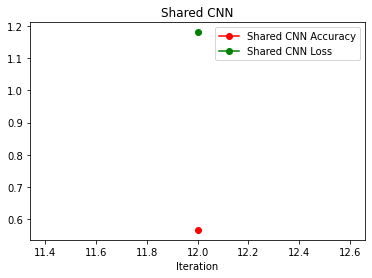

Epoch 12: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=-1.632	ent=44.67	lr=0.0010	|g|=0.2238	acc=0.5391	bl=0.58	time=1.45it/s
ctrl_step=3	loss=0.137	ent=40.90	lr=0.0010	|g|=0.2419	acc=0.5781	bl=0.58	time=1.45it/s
ctrl_step=5	loss=-3.292	ent=43.56	lr=0.0010	|g|=0.0334	acc=0.5078	bl=0.58	time=1.46it/s
ctrl_step=7	loss=-3.228	ent=41.93	lr=0.0010	|g|=0.5318	acc=0.4922	bl=0.58	time=1.36it/s


Traceback (most recent call last):


ctrl_step=9	loss=-2.001	ent=43.47	lr=0.0010	|g|=0.0493	acc=0.5312	bl=0.58	time=1.49it/s
ctrl_step=11	loss=-0.057	ent=41.98	lr=0.0010	|g|=0.1088	acc=0.5781	bl=0.58	time=1.41it/s
ctrl_step=13	loss=-0.222	ent=43.00	lr=0.0010	|g|=0.1625	acc=0.5703	bl=0.58	time=1.39it/s
ctrl_step=15	loss=-0.349	ent=43.01	lr=0.0010	|g|=0.0940	acc=0.5625	bl=0.58	time=1.42it/s
ctrl_step=17	loss=-0.150	ent=43.39	lr=0.0010	|g|=0.1434	acc=0.5703	bl=0.58	time=1.45it/s
ctrl_step=19	loss=-3.458	ent=44.25	lr=0.0010	|g|=0.1380	acc=0.5000	bl=0.58	time=1.37it/s
ctrl_step=21	loss=2.852	ent=44.29	lr=0.0010	|g|=0.0490	acc=0.6328	bl=0.58	time=1.41it/s
ctrl_step=23	loss=1.632	ent=43.86	lr=0.0010	|g|=0.0313	acc=0.6094	bl=0.58	time=1.46it/s
ctrl_step=25	loss=2.098	ent=42.75	lr=0.0010	|g|=0.3104	acc=0.6172	bl=0.58	time=1.35it/s
ctrl_step=27	loss=1.810	ent=43.74	lr=0.0010	|g|=0.0855	acc=0.6172	bl=0.58	time=1.34it/s
ctrl_step=29	loss=-0.506	ent=41.84	lr=0.0010	|g|=0.6732	acc=0.5625	bl=0.58	time=1.45it/s
ctrl_step=31	loss=4.085	en

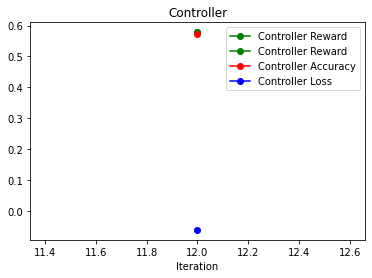

Here are 10 architectures:
[2]
[2 0]
[2 0 1]
[2 1 0 0]
[2 0 0 0 0]
[2 0 0 0 1 0]
[2 0 0 0 0 0 0]
[2 0 1 1 0 1 0 0]
[2 1 0 0 0 0 1 1 0]
[2 0 0 0 0 0 0 0 0 0]
[2 1 0 0 0 0 0 0 1 0 0]
[2 0 1 0 1 0 1 0 1 0 0 0]
val_acc=0.625
--------------------------------------------------------------------------------
[2]
[2 1]
[2 1 0]
[2 0 1 0]
[2 0 0 0 0]
[2 0 1 0 1 0]
[2 0 0 0 0 0 0]
[2 0 0 0 0 1 0 0]
[2 0 0 0 1 0 0 0 0]
[2 0 0 0 1 0 0 1 1 1]
[2 0 0 0 0 0 1 0 0 1 1]
[2 1 1 0 0 0 0 0 0 1 0 1]
val_acc=0.609375
--------------------------------------------------------------------------------
[2]
[2 0]
[2 1 0]
[2 1 0 0]
[2 0 0 0 1]
[2 0 1 0 1 0]
[2 0 1 1 0 0 0]
[2 1 0 0 0 1 0 0]
[2 0 1 0 1 0 0 1 1]
[2 0 0 0 0 0 1 0 0 0]
[2 0 0 0 0 0 0 0 0 0 0]
[2 1 0 0 0 0 0 0 0 1 0 0]
val_acc=0.6328125
--------------------------------------------------------------------------------
[2]
[2 0]
[2 0 0]
[2 0 0 0]
[2 0 0 0 0]
[2 1 0 0 1 0]
[2 1 0 0 1 1 0]
[2 0 0 0 0 0 1 1]
[2 0 0 1 1 0 0 0 1]
[2 0 1 1 0 0 1 0 0 0]
[2 1 0 0 0 

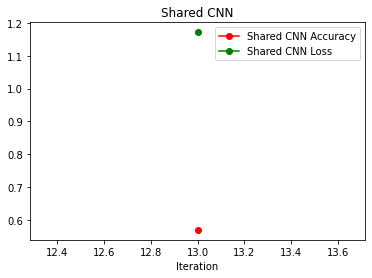

Epoch 13: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=4.009	ent=41.76	lr=0.0010	|g|=0.0749	acc=0.6875	bl=0.59	time=1.37it/s
ctrl_step=3	loss=1.767	ent=43.34	lr=0.0010	|g|=0.0430	acc=0.6250	bl=0.59	time=1.35it/s
ctrl_step=5	loss=-0.198	ent=42.07	lr=0.0010	|g|=0.0222	acc=0.5781	bl=0.59	time=1.29it/s
ctrl_step=7	loss=2.739	ent=41.03	lr=0.0010	|g|=0.3343	acc=0.6328	bl=0.59	time=1.34it/s
ctrl_step=9	loss=0.213	ent=43.16	lr=0.0010	|g|=0.1645	acc=0.5859	bl=0.59	time=1.36it/s
ctrl_step=11	loss=3.977	ent=43.32	lr=0.0010	|g|=0.1554	acc=0.6641	bl=0.59	time=1.34it/s
ctrl_step=13	loss=-2.245	ent=43.09	lr=0.0010	|g|=0.2263	acc=0.5234	bl=0.59	time=1.35it/s
ctrl_step=15	loss=-1.549	ent=43.75	lr=0.0010	|g|=0.1797	acc=0.5469	bl=0.59	time=1.40it/s
ctrl_step=17	loss=1.834	ent=42.31	lr=0.0010	|g|=0.0246	acc=0.6328	bl=0.59	time=1.29it/s
ctrl_step=19	loss=4.887	ent=42.96	lr=0.0010	|g|=0.0255	acc=0.7109	bl=0.60	time=1.35it/s
ctrl_step=21	loss=3.944	ent=43.49	lr=0.0010	|g|=0.4899	acc=0.6719	bl=0.59	time=1.36it/s
ctrl_step=23	loss=0.822	ent=44.91	

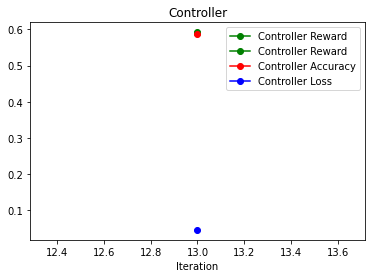

Here are 10 architectures:
[2]
[2 0]
[2 0 0]
[2 0 0 1]
[2 0 0 0 1]
[2 1 0 0 0 0]
[2 1 0 0 0 0 0]
[2 0 1 0 0 0 0 0]
[2 0 0 0 0 0 0 0 1]
[2 1 0 1 0 0 0 0 1 0]
[2 1 1 1 1 0 0 0 1 0 0]
[2 0 0 0 0 1 0 0 0 0 0 0]
val_acc=0.5625
--------------------------------------------------------------------------------
[2]
[1 0]
[2 1 0]
[1 0 0 1]
[2 1 0 0 0]
[2 0 1 0 1 0]
[2 1 0 1 0 1 0]
[2 0 0 0 0 0 0 0]
[2 0 0 0 1 0 0 0 0]
[2 0 0 0 1 1 1 0 1 0]
[2 0 1 1 0 1 0 1 0 1 0]
[2 0 0 0 1 0 0 1 0 0 0 0]
val_acc=0.4609375
--------------------------------------------------------------------------------
[2]
[2 1]
[2 1 0]
[0 0 1 0]
[2 0 0 0 0]
[2 0 0 0 0 1]
[2 0 0 1 0 0 0]
[2 0 0 1 0 0 1 0]
[0 1 0 0 0 0 0 0 0]
[1 0 1 1 0 0 1 0 0 0]
[2 0 1 0 0 1 0 0 1 0 0]
[2 0 0 0 0 0 1 1 1 0 0 0]
val_acc=0.5703125
--------------------------------------------------------------------------------
[2]
[2 0]
[2 1 0]
[2 0 0 1]
[2 0 1 0 0]
[2 0 1 1 0 0]
[2 1 0 0 0 0 0]
[2 0 1 0 1 1 0 0]
[2 0 1 1 1 0 0 0 0]
[1 1 0 0 0 1 0 1 0 0]
[2 0 0 0 

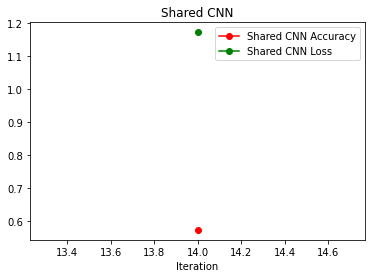

Epoch 14: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=2.891	ent=42.51	lr=0.0010	|g|=0.3861	acc=0.6562	bl=0.59	time=1.31it/s
ctrl_step=3	loss=-0.151	ent=45.64	lr=0.0010	|g|=0.5328	acc=0.5781	bl=0.59	time=1.36it/s
ctrl_step=5	loss=-0.063	ent=42.48	lr=0.0010	|g|=0.0381	acc=0.5781	bl=0.58	time=1.25it/s


Traceback (most recent call last):


ctrl_step=7	loss=0.872	ent=44.11	lr=0.0010	|g|=0.1132	acc=0.6016	bl=0.58	time=1.33it/s
ctrl_step=9	loss=-1.494	ent=43.86	lr=0.0010	|g|=0.2209	acc=0.5469	bl=0.59	time=1.28it/s
ctrl_step=11	loss=-3.645	ent=41.52	lr=0.0010	|g|=0.1044	acc=0.5000	bl=0.59	time=1.28it/s
ctrl_step=13	loss=-0.833	ent=41.30	lr=0.0010	|g|=0.4374	acc=0.5625	bl=0.59	time=1.24it/s
ctrl_step=15	loss=1.672	ent=43.04	lr=0.0010	|g|=0.1106	acc=0.6250	bl=0.59	time=1.27it/s


Traceback (most recent call last):


ctrl_step=17	loss=-1.530	ent=45.01	lr=0.0010	|g|=0.0126	acc=0.5469	bl=0.59	time=1.35it/s
ctrl_step=19	loss=0.838	ent=44.29	lr=0.0010	|g|=0.0115	acc=0.5938	bl=0.58	time=1.23it/s
ctrl_step=21	loss=3.139	ent=42.88	lr=0.0010	|g|=0.0922	acc=0.6562	bl=0.59	time=1.33it/s
ctrl_step=23	loss=0.043	ent=42.08	lr=0.0010	|g|=0.0228	acc=0.5859	bl=0.59	time=1.31it/s
ctrl_step=25	loss=1.465	ent=42.84	lr=0.0010	|g|=0.2327	acc=0.6172	bl=0.59	time=1.29it/s
ctrl_step=27	loss=3.291	ent=42.01	lr=0.0010	|g|=0.0643	acc=0.6562	bl=0.58	time=1.26it/s
ctrl_step=29	loss=-0.298	ent=43.44	lr=0.0010	|g|=0.0950	acc=0.5703	bl=0.58	time=1.27it/s
ctrl_step=31	loss=0.013	ent=43.15	lr=0.0010	|g|=0.1930	acc=0.5781	bl=0.58	time=1.25it/s
ctrl_step=33	loss=-0.331	ent=43.62	lr=0.0010	|g|=0.0531	acc=0.5703	bl=0.58	time=1.26it/s
ctrl_step=35	loss=2.122	ent=42.76	lr=0.0010	|g|=0.3907	acc=0.6250	bl=0.58	time=1.32it/s
ctrl_step=37	loss=1.404	ent=41.93	lr=0.0010	|g|=0.0179	acc=0.6172	bl=0.58	time=1.31it/s
ctrl_step=39	loss=-2.918	ent=

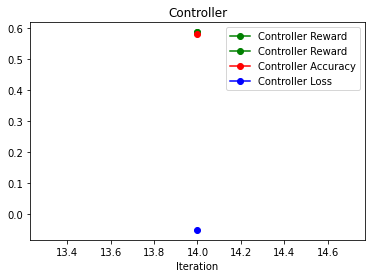

Here are 10 architectures:
[0]
[2 0]
[2 0 0]
[2 0 0 0]
[2 1 0 0 1]
[2 1 0 0 1 0]
[2 1 0 0 0 0 1]
[2 0 1 1 1 0 0 0]
[2 0 0 0 0 0 1 0 0]
[2 1 1 0 0 0 1 0 0 0]
[2 0 0 0 1 1 1 0 0 0 0]
[2 1 0 0 1 0 0 0 0 0 1 0]
val_acc=0.5078125
--------------------------------------------------------------------------------
[1]
[2 0]
[2 0 0]
[2 1 0 0]
[2 0 0 0 0]
[2 0 0 0 0 0]
[2 0 0 1 1 0 0]
[2 0 0 0 1 0 0 0]
[2 0 0 0 0 0 1 1 0]
[2 0 1 0 0 1 1 0 0 1]
[2 0 0 1 0 1 1 0 0 1 1]
[2 0 0 0 0 1 1 1 0 0 0 1]
val_acc=0.4765625
--------------------------------------------------------------------------------
[2]
[2 0]
[2 0 0]
[2 1 1 0]
[0 0 0 0 0]
[2 0 0 0 0 0]
[2 0 0 0 0 0 1]
[2 1 0 1 0 1 0 0]
[2 1 0 0 0 1 0 0 0]
[2 0 0 0 1 0 1 0 0 0]
[2 1 0 0 1 0 1 0 0 0 0]
[2 1 0 0 1 0 0 1 0 0 0 0]
val_acc=0.46875
--------------------------------------------------------------------------------
[2]
[2 0]
[2 0 0]
[0 0 0 1]
[2 0 0 0 0]
[2 0 1 0 0 0]
[2 0 0 0 0 1 0]
[2 0 0 0 0 0 1 0]
[2 0 0 1 0 0 0 0 0]
[2 0 0 0 0 0 0 0 1 0]
[2 1 0 1

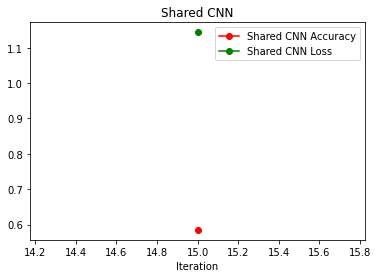

Epoch 15: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=0.537	ent=43.07	lr=0.0010	|g|=0.0300	acc=0.6016	bl=0.59	time=1.19it/s
ctrl_step=3	loss=-0.926	ent=43.46	lr=0.0010	|g|=0.0513	acc=0.5703	bl=0.60	time=1.24it/s
ctrl_step=5	loss=1.446	ent=43.38	lr=0.0010	|g|=0.0914	acc=0.6328	bl=0.60	time=1.23it/s
ctrl_step=7	loss=-4.758	ent=42.07	lr=0.0010	|g|=0.1426	acc=0.4922	bl=0.60	time=1.26it/s
ctrl_step=9	loss=0.270	ent=42.89	lr=0.0010	|g|=0.2113	acc=0.6016	bl=0.60	time=1.24it/s
ctrl_step=11	loss=-3.807	ent=42.27	lr=0.0010	|g|=0.1022	acc=0.5156	bl=0.60	time=1.25it/s
ctrl_step=13	loss=2.067	ent=42.37	lr=0.0010	|g|=0.0513	acc=0.6484	bl=0.60	time=1.21it/s
ctrl_step=15	loss=-2.389	ent=43.77	lr=0.0010	|g|=0.2051	acc=0.5391	bl=0.60	time=1.18it/s
ctrl_step=17	loss=-1.989	ent=42.45	lr=0.0010	|g|=0.0886	acc=0.5547	bl=0.60	time=1.21it/s
ctrl_step=19	loss=1.050	ent=41.17	lr=0.0010	|g|=0.2857	acc=0.6328	bl=0.60	time=1.22it/s
ctrl_step=21	loss=-0.526	ent=43.51	lr=0.0010	|g|=0.0691	acc=0.5859	bl=0.60	time=1.27it/s
ctrl_step=23	loss=3.189	ent=43.

Traceback (most recent call last):


ctrl_step=37	loss=0.422	ent=42.49	lr=0.0010	|g|=0.0772	acc=0.6094	bl=0.60	time=1.14it/s
ctrl_step=39	loss=-1.539	ent=44.05	lr=0.0010	|g|=0.1170	acc=0.5625	bl=0.60	time=1.19it/s
ctrl_step=41	loss=-2.881	ent=42.89	lr=0.0010	|g|=0.2938	acc=0.5078	bl=0.60	time=1.20it/s
ctrl_step=43	loss=-0.758	ent=42.27	lr=0.0010	|g|=0.0737	acc=0.5781	bl=0.60	time=1.14it/s
ctrl_step=45	loss=-5.178	ent=44.48	lr=0.0010	|g|=0.0692	acc=0.4844	bl=0.60	time=1.19it/s
ctrl_step=47	loss=2.551	ent=43.56	lr=0.0010	|g|=0.1821	acc=0.6641	bl=0.61	time=1.19it/s
ctrl_step=49	loss=0.762	ent=43.39	lr=0.0010	|g|=0.0547	acc=0.6172	bl=0.60	time=1.13it/s


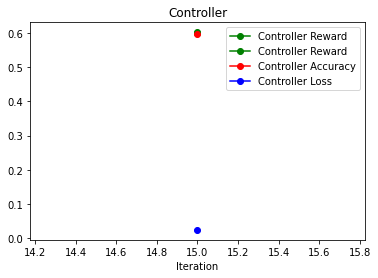

Here are 10 architectures:
[2]
[1 0]
[2 0 1]
[2 0 0 0]
[2 0 0 0 1]
[2 1 0 0 1 0]
[2 0 0 1 1 1 0]
[2 0 1 0 0 0 1 0]
[2 0 0 0 0 0 0 1 0]
[2 1 0 1 0 0 0 0 1 0]
[2 1 0 0 0 0 0 0 0 1 0]
[2 0 0 1 0 0 0 1 0 0 0 0]
val_acc=0.5859375
--------------------------------------------------------------------------------
[2]
[2 1]
[2 0 0]
[2 0 0 0]
[2 1 0 0 1]
[2 0 1 0 1 0]
[2 0 0 0 0 0 0]
[2 0 0 0 0 0 0 0]
[2 1 1 0 1 0 0 0 0]
[2 0 0 0 0 0 0 1 0 0]
[2 0 1 0 1 1 0 1 0 0 1]
[2 0 0 0 0 1 0 0 0 0 0 0]
val_acc=0.6875
--------------------------------------------------------------------------------
[2]
[2 0]
[2 0 0]
[2 0 0 0]
[2 1 0 0 0]
[2 0 1 0 1 0]
[2 0 0 0 1 0 0]
[2 0 0 0 0 0 0 1]
[2 0 0 0 0 0 1 0 0]
[2 1 0 0 0 1 1 1 0 0]
[2 0 1 0 0 0 1 0 0 0 0]
[2 1 0 1 0 0 0 0 0 0 1 0]
val_acc=0.625
--------------------------------------------------------------------------------
[2]
[1 0]
[2 0 0]
[2 0 0 0]
[2 0 0 0 0]
[2 1 0 0 1 0]
[2 1 1 1 0 0 0]
[2 1 0 0 0 0 0 0]
[2 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 0 0 1 0]
[2 0 0 0 0 0 

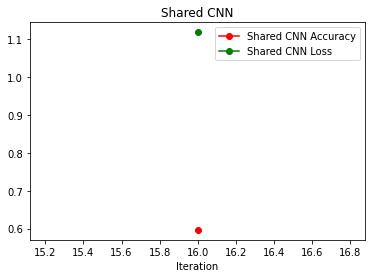

Epoch 16: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=1.208	ent=43.25	lr=0.0010	|g|=0.3282	acc=0.6328	bl=0.61	time=1.18it/s
ctrl_step=3	loss=2.011	ent=43.95	lr=0.0010	|g|=0.1575	acc=0.6562	bl=0.61	time=1.25it/s
ctrl_step=5	loss=-1.305	ent=43.48	lr=0.0010	|g|=0.0592	acc=0.5781	bl=0.62	time=1.12it/s


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)


ctrl_step=7	loss=2.782	ent=43.13	lr=0.0010	|g|=0.2061	acc=0.6875	bl=0.61	time=1.16it/s
ctrl_step=9	loss=-9.198	ent=42.59	lr=0.0010	|g|=0.1835	acc=0.4219	bl=0.62	time=1.20it/s
ctrl_step=11	loss=1.114	ent=42.09	lr=0.0010	|g|=0.0877	acc=0.6328	bl=0.61	time=1.15it/s
ctrl_step=13	loss=-1.591	ent=42.59	lr=0.0010	|g|=0.0951	acc=0.5781	bl=0.61	time=1.19it/s
ctrl_step=15	loss=-0.076	ent=41.02	lr=0.0010	|g|=0.1113	acc=0.6094	bl=0.62	time=1.17it/s
ctrl_step=17	loss=-1.181	ent=40.86	lr=0.0010	|g|=0.4152	acc=0.5703	bl=0.61	time=1.19it/s
ctrl_step=19	loss=3.853	ent=41.47	lr=0.0010	|g|=0.0910	acc=0.7266	bl=0.62	time=1.22it/s
ctrl_step=21	loss=1.306	ent=42.55	lr=0.0010	|g|=0.0233	acc=0.6406	bl=0.61	time=1.22it/s
ctrl_step=23	loss=0.169	ent=43.12	lr=0.0010	|g|=0.3426	acc=0.6172	bl=0.62	time=1.11it/s
ctrl_step=25	loss=-3.542	ent=44.34	lr=0.0010	|g|=0.4345	acc=0.5312	bl=0.61	time=1.23it/s
ctrl_step=27	loss=-3.367	ent=42.43	lr=0.0010	|g|=0.0984	acc=0.5312	bl=0.61	time=1.17it/s
ctrl_step=29	loss=0.966	ent=

Traceback (most recent call last):


ctrl_step=33	loss=0.691	ent=41.39	lr=0.0010	|g|=0.0782	acc=0.6250	bl=0.62	time=1.13it/s
ctrl_step=35	loss=6.516	ent=41.08	lr=0.0010	|g|=0.2691	acc=0.7656	bl=0.61	time=1.16it/s
ctrl_step=37	loss=1.095	ent=41.59	lr=0.0010	|g|=0.2246	acc=0.6406	bl=0.62	time=1.16it/s
ctrl_step=39	loss=-2.024	ent=43.08	lr=0.0010	|g|=0.0689	acc=0.5703	bl=0.62	time=1.14it/s
ctrl_step=41	loss=0.107	ent=42.28	lr=0.0010	|g|=0.0145	acc=0.6172	bl=0.62	time=1.19it/s


Traceback (most recent call last):


ctrl_step=43	loss=-2.247	ent=43.17	lr=0.0010	|g|=0.1397	acc=0.5703	bl=0.62	time=1.13it/s
ctrl_step=45	loss=-0.579	ent=42.64	lr=0.0010	|g|=0.1637	acc=0.6016	bl=0.62	time=1.14it/s


Traceback (most recent call last):


ctrl_step=47	loss=4.808	ent=42.91	lr=0.0010	|g|=0.5004	acc=0.7344	bl=0.62	time=1.11it/s
ctrl_step=49	loss=-0.008	ent=44.71	lr=0.0010	|g|=0.1782	acc=0.6172	bl=0.62	time=1.15it/s


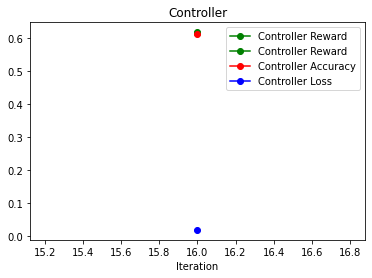

Here are 10 architectures:
[2]
[2 1]
[2 1 0]
[2 0 1 1]
[2 0 1 0 0]
[2 0 0 0 0 0]
[2 1 0 0 1 0 1]
[2 1 0 0 0 1 1 0]
[2 0 0 0 0 1 0 0 0]
[2 0 0 0 0 0 1 0 0 1]
[2 1 0 0 1 1 0 0 0 0 1]
[2 1 0 1 0 0 0 1 1 1 1 0]
val_acc=0.59375
--------------------------------------------------------------------------------
[0]
[2 0]
[2 0 0]
[2 0 0 0]
[2 0 0 0 1]
[2 0 0 0 0 0]
[2 0 0 0 0 1 0]
[2 1 1 1 1 0 0 1]
[2 1 0 0 1 1 1 0 1]
[2 1 0 0 0 1 0 1 1 0]
[2 0 0 0 0 1 1 0 0 1 0]
[2 1 1 0 0 0 1 0 0 0 0 0]
val_acc=0.5234375
--------------------------------------------------------------------------------
[2]
[2 0]
[0 0 0]
[2 0 1 0]
[2 1 0 1 0]
[2 0 0 0 1 1]
[2 0 1 0 1 0 1]
[2 1 0 0 1 0 1 0]
[2 0 1 1 0 0 1 0 1]
[2 0 0 0 1 0 0 1 0 0]
[2 1 0 0 1 1 1 1 1 0 0]
[2 0 0 0 0 0 0 0 0 1 1 1]
val_acc=0.6484375
--------------------------------------------------------------------------------
[2]
[2 0]
[2 0 0]
[2 1 0 0]
[2 1 1 1 1]
[2 0 0 1 0 0]
[2 0 0 0 0 0 0]
[2 0 0 0 0 0 0 0]
[1 1 1 0 1 1 1 1 0]
[2 0 0 0 0 1 1 0 0 1]
[2 1 0 0

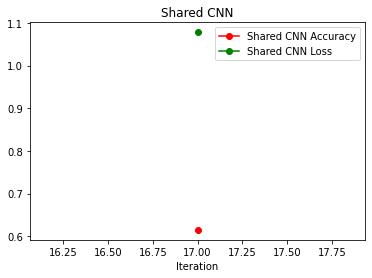

Epoch 17: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=-0.352	ent=44.41	lr=0.0010	|g|=0.0249	acc=0.6094	bl=0.62	time=1.13it/s


Traceback (most recent call last):


ctrl_step=3	loss=-0.374	ent=45.46	lr=0.0010	|g|=0.3348	acc=0.6094	bl=0.62	time=1.19it/s
ctrl_step=5	loss=1.560	ent=44.93	lr=0.0010	|g|=0.0767	acc=0.6562	bl=0.63	time=1.13it/s
ctrl_step=7	loss=0.510	ent=44.52	lr=0.0010	|g|=0.2381	acc=0.6406	bl=0.63	time=1.12it/s


Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):


ctrl_step=9	loss=0.840	ent=43.66	lr=0.0010	|g|=0.5338	acc=0.6484	bl=0.63	time=0.74it/s
ctrl_step=11	loss=0.839	ent=42.49	lr=0.0010	|g|=0.0230	acc=0.6484	bl=0.63	time=1.12it/s
ctrl_step=13	loss=4.162	ent=43.06	lr=0.0010	|g|=0.0667	acc=0.7188	bl=0.63	time=1.07it/s


Traceback (most recent call last):


ctrl_step=15	loss=1.269	ent=41.64	lr=0.0010	|g|=0.2413	acc=0.6562	bl=0.63	time=1.17it/s
ctrl_step=17	loss=-0.763	ent=42.54	lr=0.0010	|g|=0.2780	acc=0.6016	bl=0.63	time=1.11it/s
ctrl_step=19	loss=-1.616	ent=42.46	lr=0.0010	|g|=0.0949	acc=0.5781	bl=0.62	time=1.11it/s
ctrl_step=21	loss=1.691	ent=42.67	lr=0.0010	|g|=0.0672	acc=0.6641	bl=0.62	time=1.13it/s
ctrl_step=23	loss=-0.259	ent=40.36	lr=0.0010	|g|=0.4696	acc=0.6172	bl=0.63	time=1.19it/s
ctrl_step=25	loss=1.894	ent=42.03	lr=0.0010	|g|=0.0266	acc=0.6719	bl=0.63	time=1.16it/s
ctrl_step=27	loss=-2.911	ent=42.75	lr=0.0010	|g|=0.0968	acc=0.5547	bl=0.63	time=1.06it/s
ctrl_step=29	loss=0.857	ent=42.91	lr=0.0010	|g|=0.0290	acc=0.6484	bl=0.63	time=1.15it/s
ctrl_step=31	loss=3.594	ent=43.68	lr=0.0010	|g|=0.3486	acc=0.7031	bl=0.63	time=1.15it/s
ctrl_step=33	loss=-0.826	ent=44.57	lr=0.0010	|g|=0.1966	acc=0.6016	bl=0.62	time=1.11it/s
ctrl_step=35	loss=0.137	ent=42.78	lr=0.0010	|g|=0.1739	acc=0.6250	bl=0.63	time=1.11it/s
ctrl_step=37	loss=-1.619	en

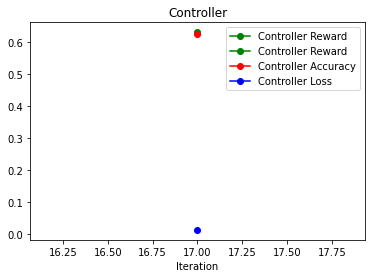

Here are 10 architectures:
[2]
[2 0]
[2 1 0]
[2 1 0 0]
[2 0 1 0 1]
[2 1 0 0 1 0]
[2 0 1 1 0 0 0]
[2 1 0 1 0 0 0 1]
[2 1 0 0 0 0 0 0 1]
[2 0 0 0 0 0 0 0 0 0]
[2 0 0 0 1 0 0 1 0 0 0]
[2 0 0 1 0 0 0 0 0 0 1 0]
val_acc=0.5234375
--------------------------------------------------------------------------------
[0]
[2 1]
[2 1 0]
[2 0 0 0]
[2 1 0 0 0]
[2 1 0 0 1 0]
[2 0 1 0 1 1 0]
[2 0 0 1 0 0 0 0]
[2 0 0 0 0 0 1 0 1]
[2 1 0 0 0 0 0 1 1 1]
[2 0 0 1 0 0 1 1 0 0 0]
[2 1 0 0 0 1 1 0 1 0 1 0]
val_acc=0.453125
--------------------------------------------------------------------------------
[2]
[2 0]
[2 1 1]
[2 0 0 0]
[2 1 0 0 1]
[2 0 1 0 0 1]
[2 1 0 0 0 0 1]
[1 0 0 0 0 0 0 0]
[2 1 0 1 0 0 1 0 0]
[0 1 1 0 1 0 1 0 1 0]
[2 1 0 0 1 1 0 0 0 1 1]
[2 0 1 0 1 1 0 0 0 0 0 0]
val_acc=0.515625
--------------------------------------------------------------------------------
[0]
[2 0]
[2 0 0]
[2 0 0 1]
[2 0 0 0 0]
[2 0 0 0 0 0]
[2 0 1 0 0 0 1]
[2 1 0 1 0 0 0 1]
[2 1 0 0 0 0 0 0 0]
[2 1 0 0 1 0 0 0 1 1]
[2 0 0 0

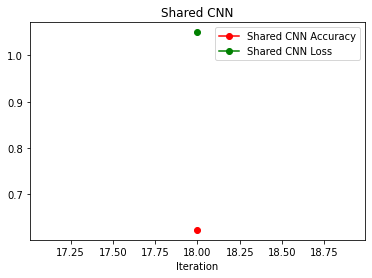

Epoch 18: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Traceback (most recent call last):


ctrl_step=1	loss=1.227	ent=45.32	lr=0.0010	|g|=0.5186	acc=0.6641	bl=0.64	time=1.05it/s
ctrl_step=3	loss=1.940	ent=43.06	lr=0.0010	|g|=0.0187	acc=0.6797	bl=0.64	time=1.09it/s
ctrl_step=5	loss=-2.181	ent=43.74	lr=0.0010	|g|=0.2071	acc=0.5938	bl=0.64	time=1.08it/s
ctrl_step=7	loss=-7.534	ent=42.50	lr=0.0010	|g|=0.0576	acc=0.4922	bl=0.64	time=1.09it/s
ctrl_step=9	loss=2.988	ent=42.99	lr=0.0010	|g|=0.1354	acc=0.7188	bl=0.65	time=1.04it/s
ctrl_step=11	loss=1.506	ent=43.16	lr=0.0010	|g|=0.0349	acc=0.6797	bl=0.65	time=1.07it/s
ctrl_step=13	loss=-0.478	ent=42.02	lr=0.0010	|g|=0.5066	acc=0.6328	bl=0.65	time=1.13it/s
ctrl_step=15	loss=-3.751	ent=44.58	lr=0.0010	|g|=0.0805	acc=0.5703	bl=0.65	time=1.14it/s
ctrl_step=17	loss=0.187	ent=45.31	lr=0.0010	|g|=0.1373	acc=0.6484	bl=0.65	time=1.02it/s
ctrl_step=19	loss=-1.405	ent=43.17	lr=0.0010	|g|=0.0670	acc=0.6172	bl=0.65	time=1.08it/s
ctrl_step=21	loss=-1.435	ent=43.83	lr=0.0010	|g|=0.0171	acc=0.6094	bl=0.65	time=1.13it/s
ctrl_step=23	loss=0.188	ent=42.

Traceback (most recent call last):


ctrl_step=25	loss=0.207	ent=41.20	lr=0.0010	|g|=0.6471	acc=0.6328	bl=0.63	time=1.07it/s
ctrl_step=27	loss=4.052	ent=43.92	lr=0.0010	|g|=0.0411	acc=0.7266	bl=0.64	time=1.07it/s
ctrl_step=29	loss=0.587	ent=43.86	lr=0.0010	|g|=0.1559	acc=0.6484	bl=0.64	time=1.06it/s
ctrl_step=31	loss=0.981	ent=43.83	lr=0.0010	|g|=0.0201	acc=0.6641	bl=0.64	time=1.06it/s
ctrl_step=33	loss=-0.175	ent=43.41	lr=0.0010	|g|=0.0193	acc=0.6328	bl=0.64	time=1.05it/s
ctrl_step=35	loss=-0.931	ent=43.18	lr=0.0010	|g|=0.2655	acc=0.6172	bl=0.64	time=1.12it/s
ctrl_step=37	loss=-1.025	ent=42.20	lr=0.0010	|g|=0.2978	acc=0.6172	bl=0.64	time=1.05it/s
ctrl_step=39	loss=1.911	ent=44.25	lr=0.0010	|g|=0.1354	acc=0.6875	bl=0.65	time=1.05it/s
ctrl_step=41	loss=3.190	ent=43.27	lr=0.0010	|g|=0.1879	acc=0.7188	bl=0.64	time=1.09it/s
ctrl_step=43	loss=2.402	ent=45.14	lr=0.0010	|g|=0.1107	acc=0.6875	bl=0.64	time=1.05it/s
ctrl_step=45	loss=-0.154	ent=44.21	lr=0.0010	|g|=0.3004	acc=0.6406	bl=0.65	time=1.09it/s


Traceback (most recent call last):


ctrl_step=47	loss=0.676	ent=40.65	lr=0.0010	|g|=0.8255	acc=0.6562	bl=0.64	time=1.01it/s
ctrl_step=49	loss=4.699	ent=44.58	lr=0.0010	|g|=0.2530	acc=0.7578	bl=0.64	time=1.05it/s


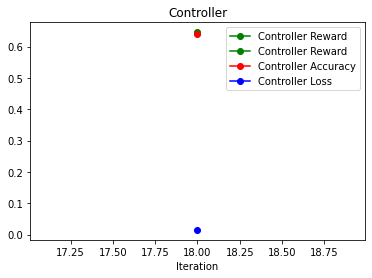

Here are 10 architectures:
[2]
[2 0]
[2 0 1]
[2 1 0 1]
[2 0 0 0 0]
[2 0 0 0 1 0]
[2 0 1 0 1 0 0]
[2 0 1 0 0 0 0 1]
[1 1 0 1 1 0 0 0 0]
[2 1 0 0 0 1 0 0 0 0]
[2 0 0 1 1 0 0 1 0 1 0]
[2 0 0 0 1 0 1 0 1 0 0 0]
val_acc=0.640625
--------------------------------------------------------------------------------
[1]
[2 0]
[2 0 0]
[2 0 0 0]
[2 1 0 0 1]
[2 1 0 1 0 0]
[2 1 0 1 0 0 0]
[2 1 0 0 1 0 1 1]
[2 1 1 1 0 0 0 0 0]
[2 0 1 0 1 1 1 1 0 0]
[0 0 0 1 0 0 0 1 0 0 1]
[2 1 1 0 1 1 0 0 1 1 1 0]
val_acc=0.421875
--------------------------------------------------------------------------------
[2]
[0 0]
[2 1 1]
[1 0 0 0]
[2 0 0 0 0]
[1 0 0 0 0 1]
[2 0 0 0 1 0 0]
[1 0 0 0 0 0 1 0]
[2 0 0 0 0 0 0 0 1]
[2 0 0 0 0 0 0 0 1 0]
[2 0 0 1 0 0 1 0 0 1 0]
[2 0 1 0 0 0 0 0 0 0 0 0]
val_acc=0.4921875
--------------------------------------------------------------------------------
[2]
[2 0]
[1 0 1]
[2 1 0 1]
[2 0 0 1 0]
[2 0 1 0 1 0]
[2 0 0 0 0 1 0]
[2 0 0 0 0 1 0 0]
[2 1 0 0 0 1 1 1 0]
[2 0 1 0 0 0 1 1 0 0]
[2 0 0 0

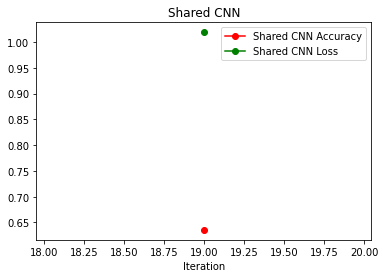

Epoch 19: Training controller


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ctrl_step=1	loss=-2.294	ent=42.62	lr=0.0010	|g|=0.0376	acc=0.6016	bl=0.65	time=1.01it/s
ctrl_step=3	loss=2.232	ent=43.48	lr=0.0010	|g|=0.0770	acc=0.6953	bl=0.65	time=1.03it/s
ctrl_step=5	loss=4.337	ent=42.47	lr=0.0010	|g|=0.3133	acc=0.7656	bl=0.65	time=1.02it/s
ctrl_step=7	loss=0.915	ent=43.29	lr=0.0010	|g|=0.1182	acc=0.6719	bl=0.66	time=1.02it/s
ctrl_step=9	loss=0.913	ent=43.09	lr=0.0010	|g|=0.0369	acc=0.6719	bl=0.65	time=1.03it/s
ctrl_step=11	loss=0.459	ent=43.88	lr=0.0010	|g|=0.0593	acc=0.6641	bl=0.66	time=1.02it/s


Traceback (most recent call last):


In [ ]:
if args['resume']:
    if os.path.isfile(args['resume']):
        print("Loading checkpoint '{}'".format(args['resume']))
        checkpoint = torch.load(args['resume'])
        start_epoch = checkpoint['epoch']
        # args = checkpoint['args']
        print(checkpoint.keys())
        shared_cnn.load_state_dict(checkpoint['shared_cnn_state_dict'])
        controller.load_state_dict(checkpoint['controller_state_dict'])
        shared_cnn_optimizer.load_state_dict(checkpoint['shared_cnn_optimizer'])
        controller_optimizer.load_state_dict(checkpoint['controller_optimizer'])
        shared_cnn_scheduler.optimizer = shared_cnn_optimizer  # Not sure if this actually works
        print("Loaded checkpoint '{}' (epoch {})"
              .format(args['resume'], checkpoint['epoch']))
    else:
        raise ValueError("No checkpoint found at '{}'".format(args['resume']))
else:
  start_epoch = 0

if not args['fixed_arc']:
    train_enas(start_epoch,
                controller,
                shared_cnn,
                data_loaders,
                shared_cnn_optimizer,
                controller_optimizer,
                shared_cnn_scheduler)
else:
    assert args['resume'] != '', 'A pretrained model should be used when training a fixed architecture.'
    train_fixed(start_epoch,
                controller,
                shared_cnn,
                data_loaders)